In [28]:
from datetime import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn
pd.options.mode.chained_assignment = None


In [27]:
player_map = {
    'Karl Anthony Towns': 'townska01',
    'Anthony Davis': 'davisan02',
    'Kemba Walker': 'walkeke02'
}

In [26]:
team_url = 'https://www.basketball-reference.com/teams/{team}/{year}/gamelog-advanced/'

def clean_date(date_str):
    date_obj = dt.strptime(date_str, '%a, %b %d, %Y')
    return date_obj.strftime('%Y-%m-%d')

columns = ['Rk', 'G', 'Date', 'Opp', 'W/L', 'Tm', 'Opp Pts', 'ORtg',
    'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
    'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp eFG%', 'Opp TOV%', 'DRB%', 'Opp FT/FGA']

numeric_columns = ['Rk', 'G', 'Tm', 'Opp Pts', 'ORtg',
    'DRtg', 'Pace', 'FTr', '3PAr', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%',
    'eFG%', 'TOV%', 'ORB%', 'FT/FGA', 'Opp eFG%', 'Opp TOV%', 'DRB%', 'Opp FT/FGA']
    
# columns that should be displayed in ascending order
ascending_columns = set(['Opp Pts', 'DRtg', 'TOV%', 'Opp eFG%', 'Opp TOV%', 'Opp FT/FGA'])
    
def get_team_schedule(team, year):
    url = team_url.format(team=team, year=year)
    raw_sch = pd.read_html(url, header=1)[0]
    
    sch = raw_sch[raw_sch['G'] != 'G']
    sch.rename(index=str, columns={
        "Opp.1": "Opp Pts",
        'FT/FGA.1': "Opp FT/FGA",
        'eFG%.1': 'Opp eFG%',
        'TOV%.1': 'Opp TOV%'
    }, inplace=True)
    sch[numeric_columns] = sch[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # only get games that have been played
    sch = sch[sch['Opp'].notnull()]
    return sch[columns]

In [25]:
game_log_url = 'https://www.basketball-reference.com/players/c/{player_id}/gamelog/{year}'

INJURY_STATES = set([
    'Inactive',
    'Did Not Play',
    'Did Not Dress',
    # 'Not With Team',
    np.nan
])

START_YEAR = 2003
END_YEAR = 2019


def status_func(status):
    if status in INJURY_STATES:
        return 'Injured'
    else:
        return 'Played'
    

def make_player_id(player_name):
    fn, ln = player_name.split(' ')
    return "{0}{1}{2}".format(ln[:5].lower(), fn[:2].lower(), "01")
    

def join_with_team(team, year, game_logs):
    team_sch = get_team_schedule(team, year)
    team_sch['year'] = year
    
    merged = pd.merge(team_sch, game_logs, how='left', on='Date')
    merged['status'] = merged['GS'].apply(status_func)
    return merged
    
    
def get_game_log(player_name, debug=False, start_year=START_YEAR, end_year=END_YEAR):
    
    if player_name not in player_map:
        player_id = make_player_id(player_name)
    else:
        player_id = player_map[player_name]
    
    game_logs = []
    for year in range(start_year, end_year + 1):
        url = game_log_url.format(player_id=player_id, year=year)
        if debug:
            print("Getting URL for: ", url)
        
        try:
            table = pd.read_html(url)[-1]
        except ValueError:
            continue
        
        # clean
        filtered_logs = table[table['Rk'] != 'Rk']
        filtered_logs['Rk'] = pd.to_numeric(filtered_logs['Rk'])
        
        relevant_columns = ['GS', '+/-', 'PTS', 'Date', 'Tm']
        filtered_logs = filtered_logs[relevant_columns]
                
        # join with team schedule
        team = set(filtered_logs.head()['Tm'])
        assert len(team) == 1, 'More than one team'
        final_log = join_with_team(team.pop(), year, filtered_logs)
        game_logs.append(final_log)
    
    return pd.concat(game_logs, sort=False)


def plot_viz(game_logs):
    _statuses = ['Played', 'Injured']
    fg = seaborn.FacetGrid(data=game_logs, hue='status', hue_order=_statuses, aspect=4)
    fg.map(plt.scatter, 'G', 'year').add_legend()

    
def plot_stat(data, stat, annotate):
    _statuses = ['Played', 'Injured']
    fg = seaborn.FacetGrid(data=data, hue='status', hue_order=_statuses,
                           aspect=4.5, palette=seaborn.color_palette("muted"))
    fg.map(plt.bar, 'rank', stat)
    fg.fig.text(0, 1, str(annotate))


def _format_annotation(info):
    return "\n".join(str(info).split('\n')[1:])


def plot_all_stats(game_logs, year):
    year_game_logs = game_logs[game_logs['year'] == year]
    gb = year_game_logs.groupby(by='status')
    print(gb.count()['G'], "\n")
    
    for col in numeric_columns[3:]:
        annotate = _format_annotation(gb.mean()[col])
        
        data = year_game_logs.sort_values(by=col, ascending=col in ascending_columns)
        data['rank'] = np.arange(len(data))
        plot_stat(data, col, annotate)

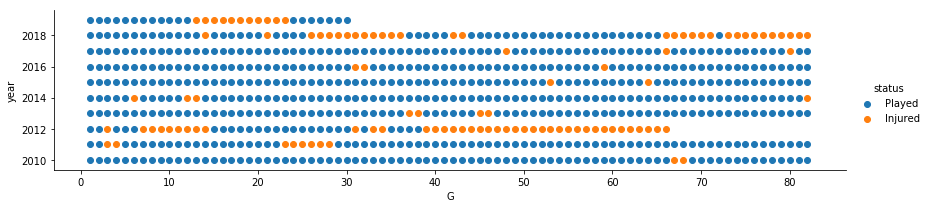

In [138]:
curry = get_game_log('Stephen Curry', start_year=2007)
plot_viz(curry)


In [23]:
bi = get_game_log('Brandon Ingram', start_year=2019, end_year=2019)


status
Injured     4
Played     24
Name: G, dtype: int64 



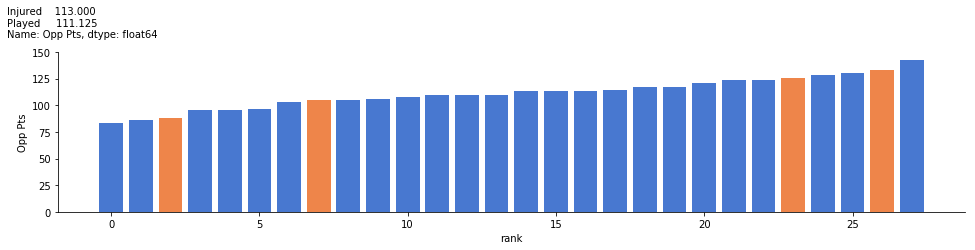

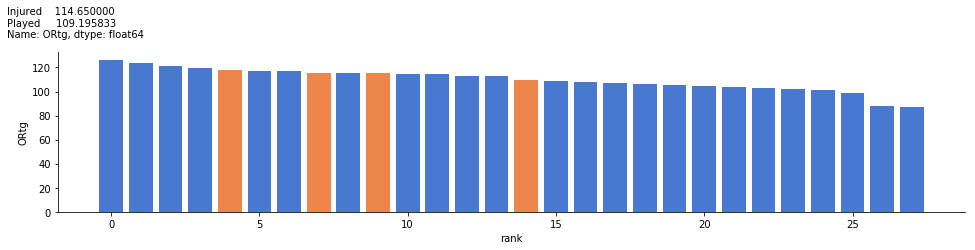

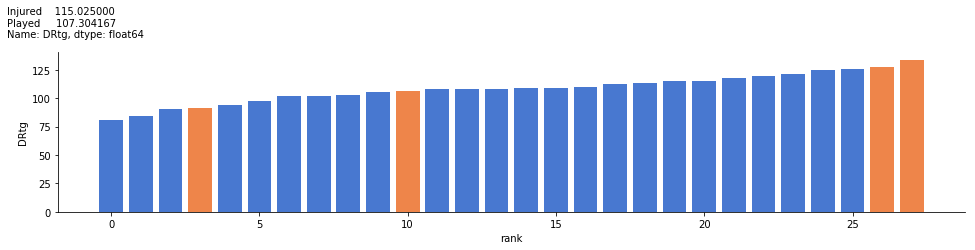

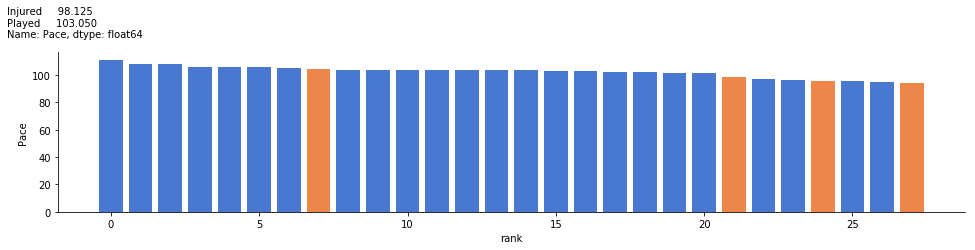

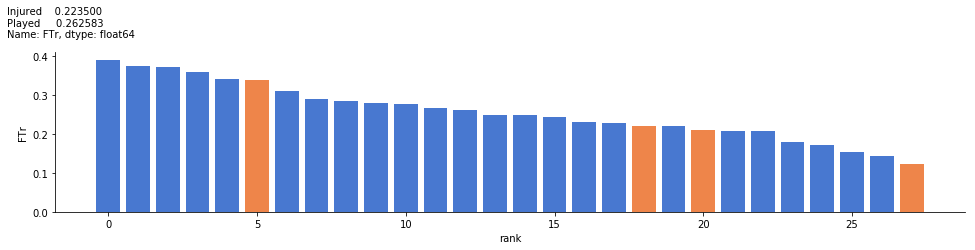

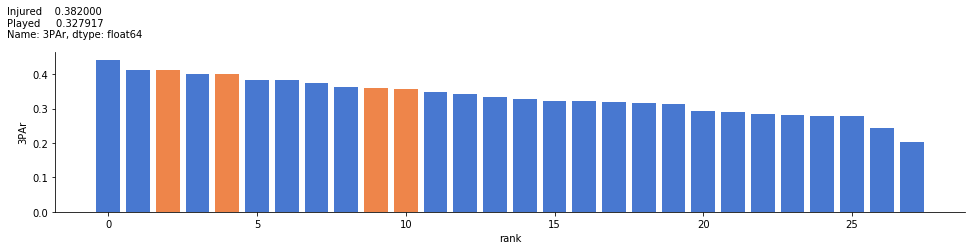

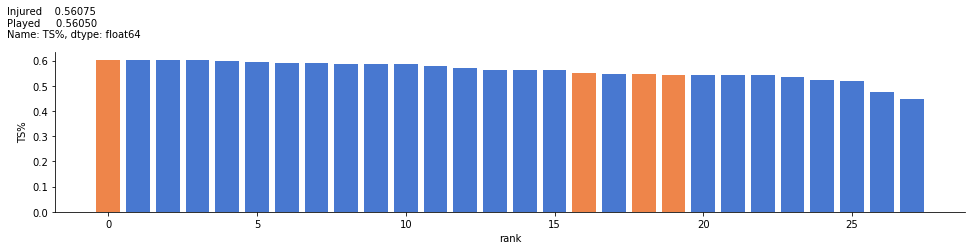

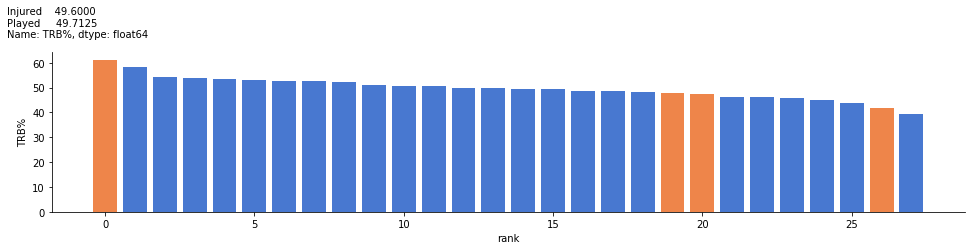

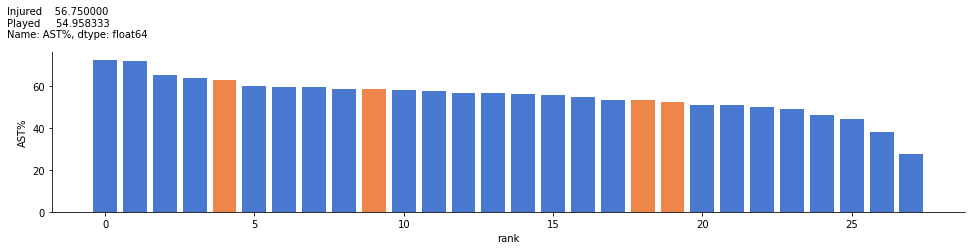

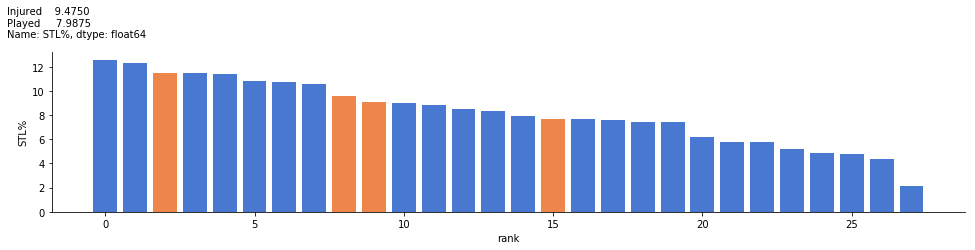

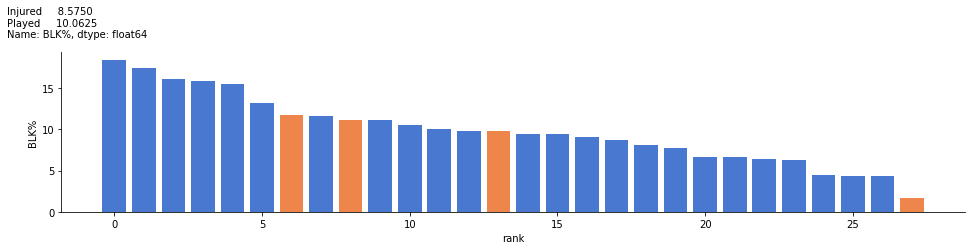

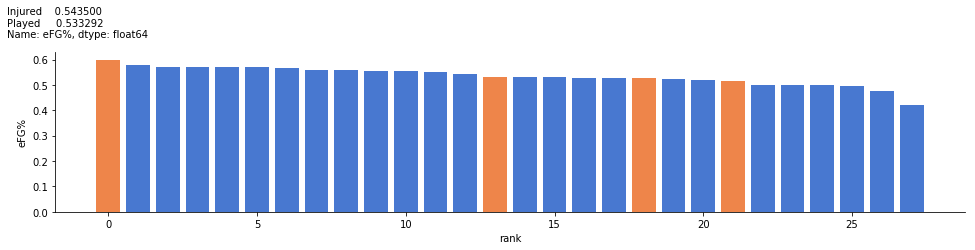

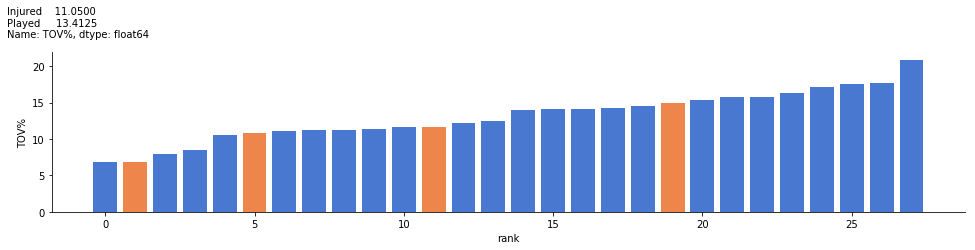

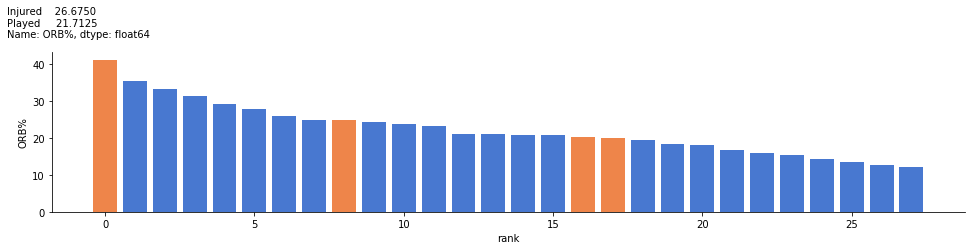

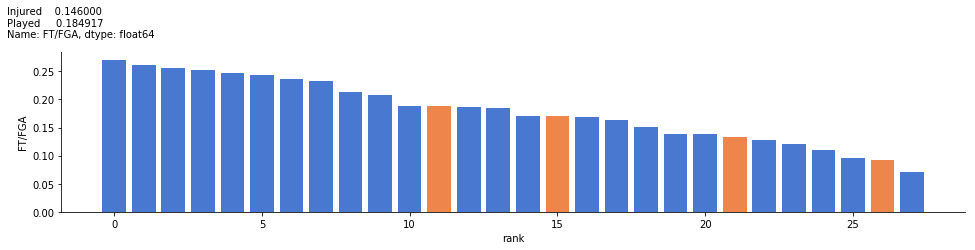

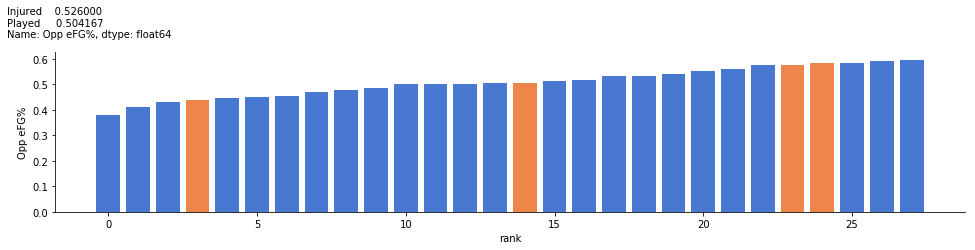

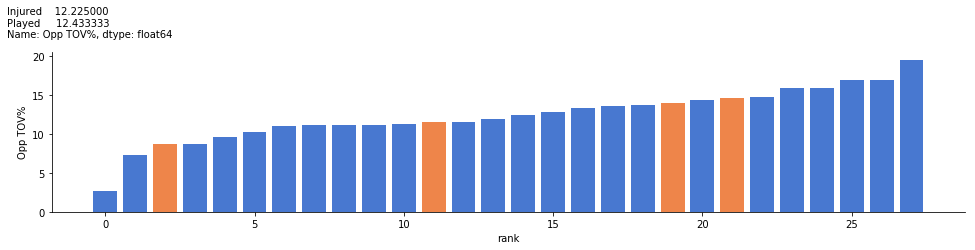

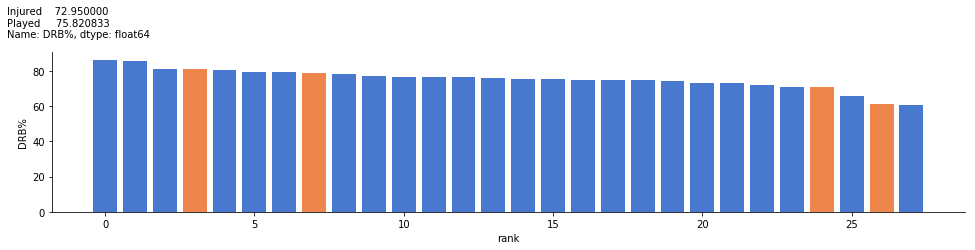

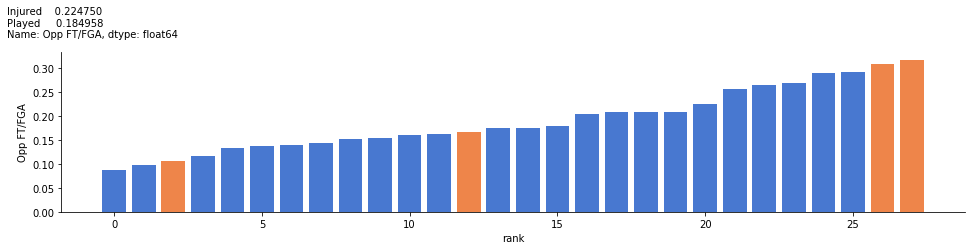

In [24]:
bi
plot_all_stats(bi, 2019)

status
Injured    11
Played     19
Name: G, dtype: int64 



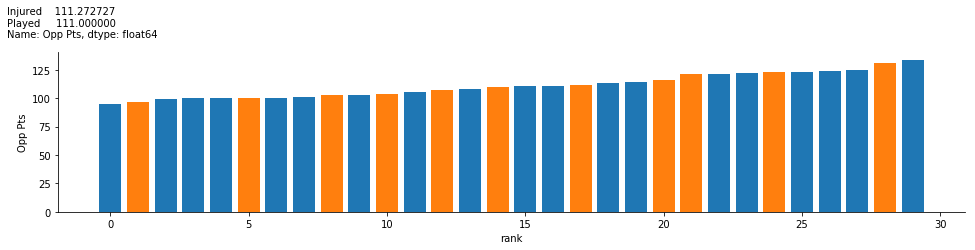

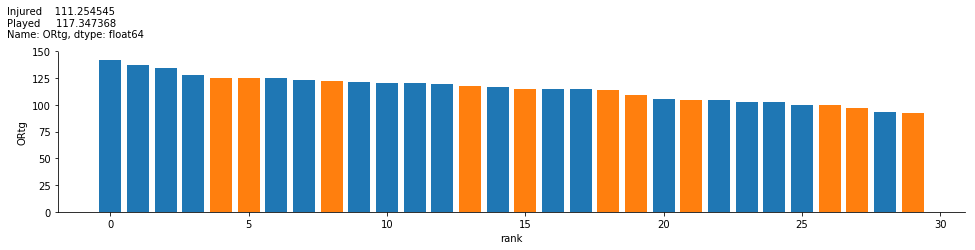

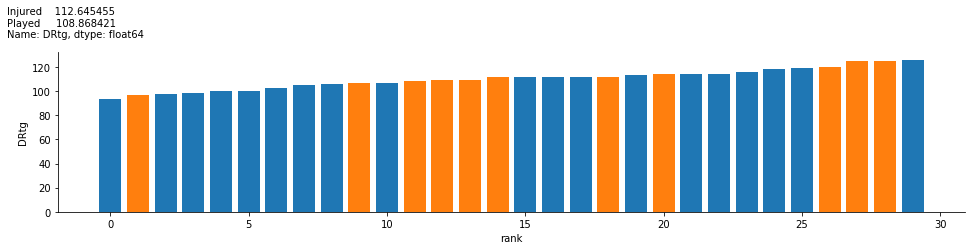

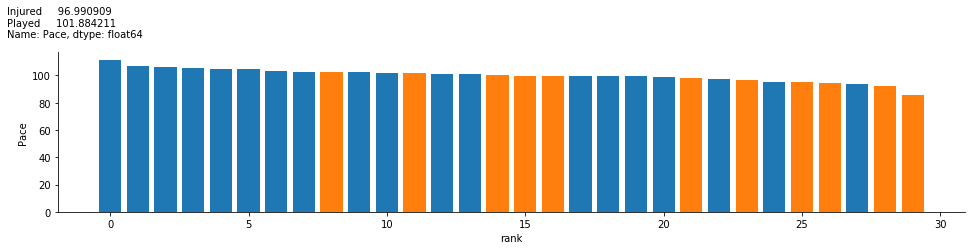

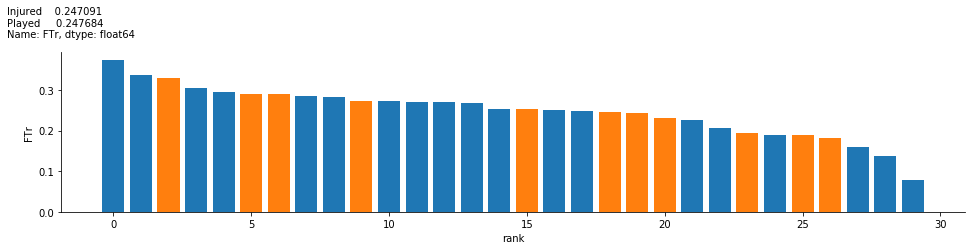

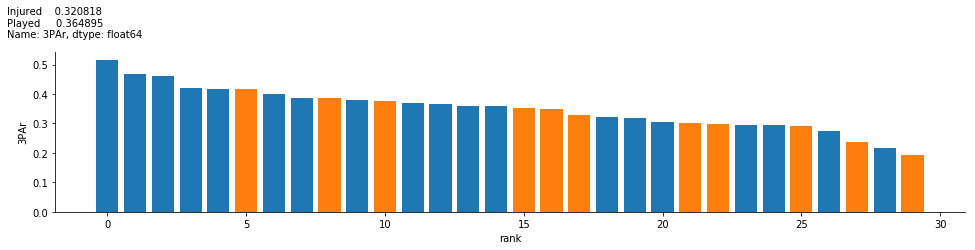

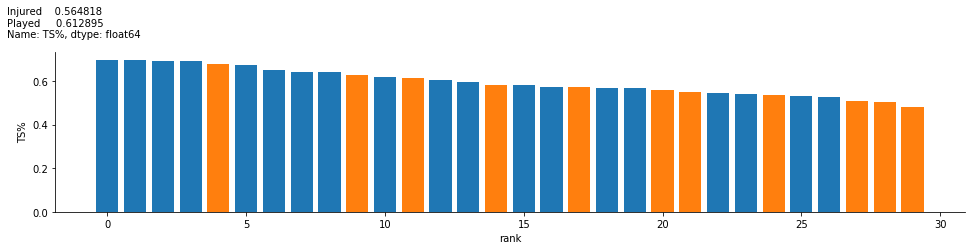

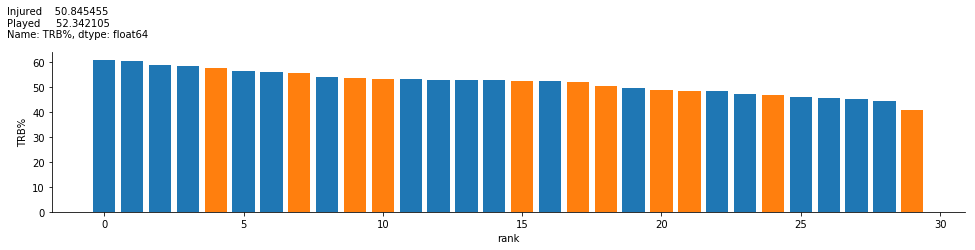

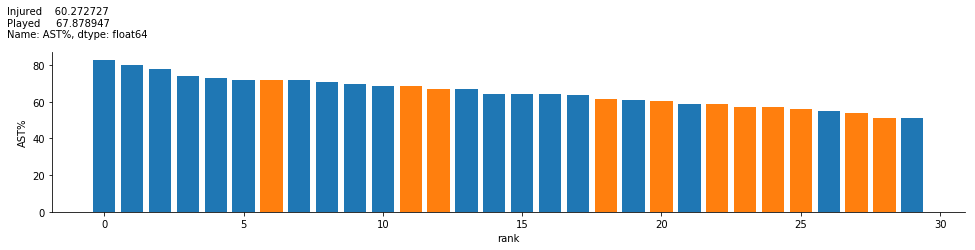

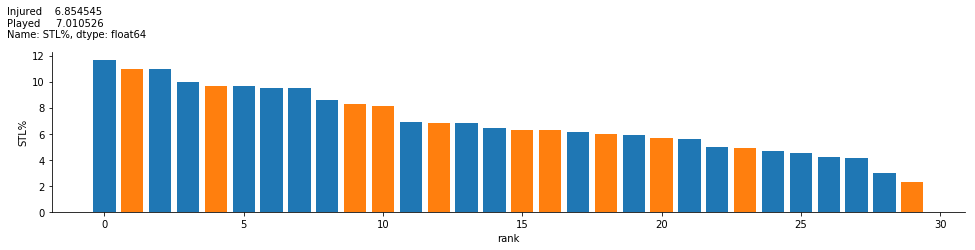

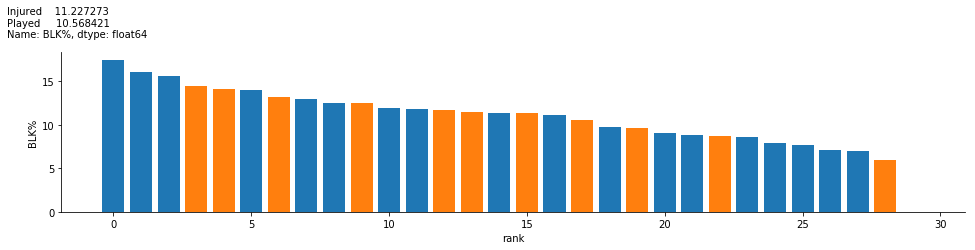

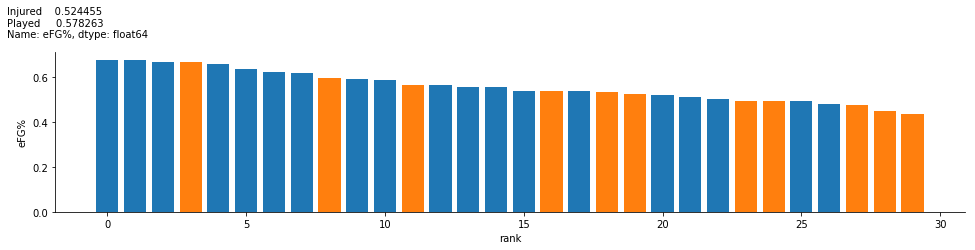

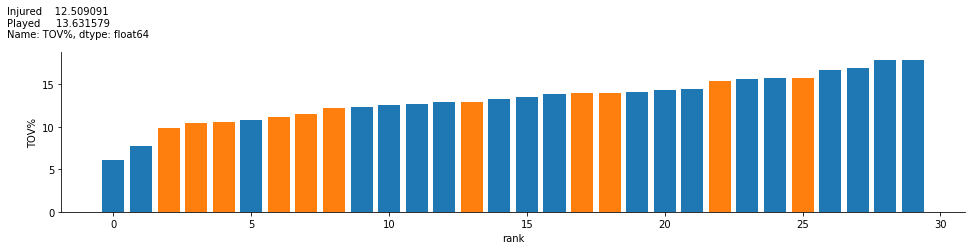

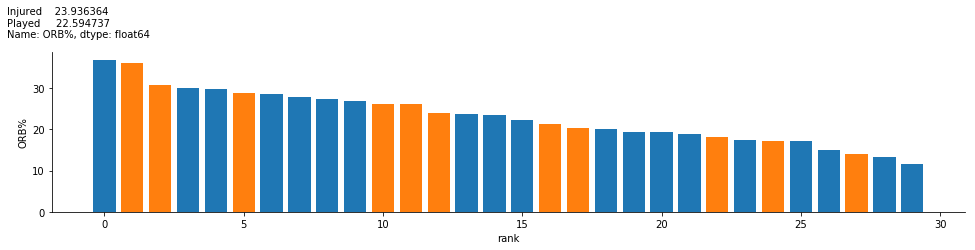

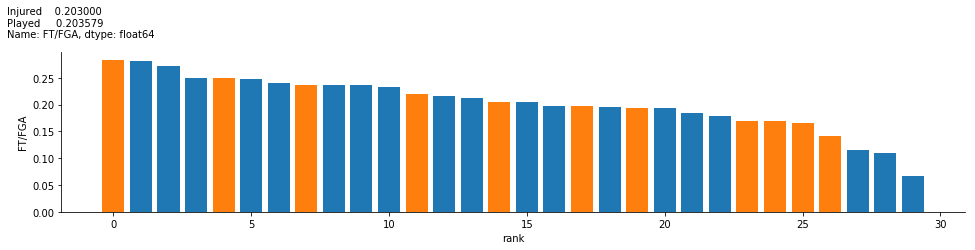

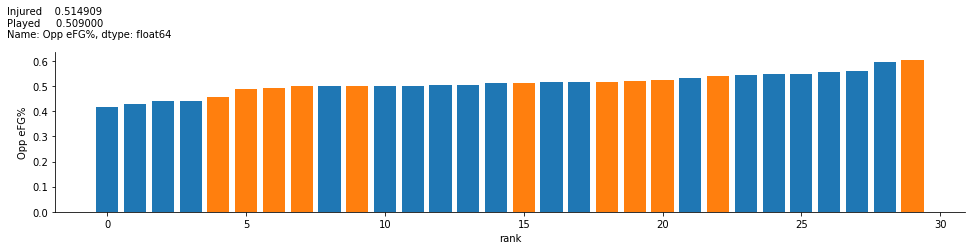

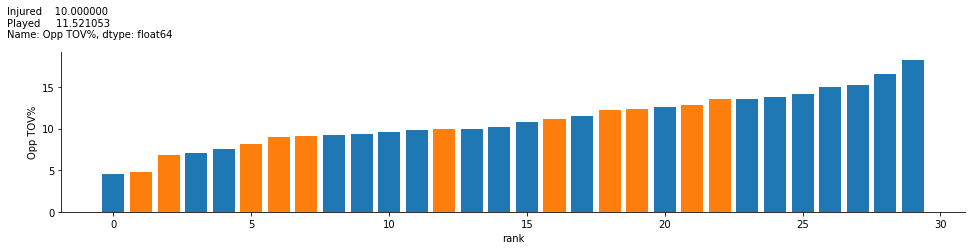

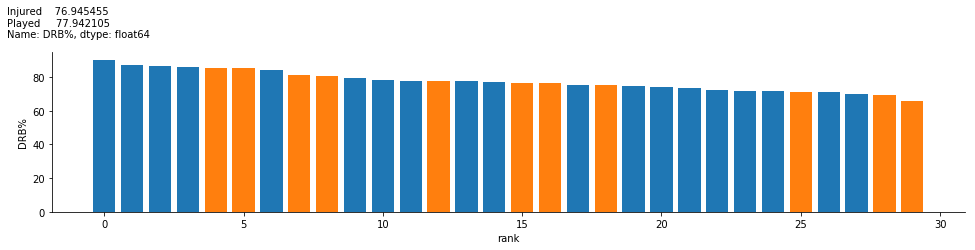

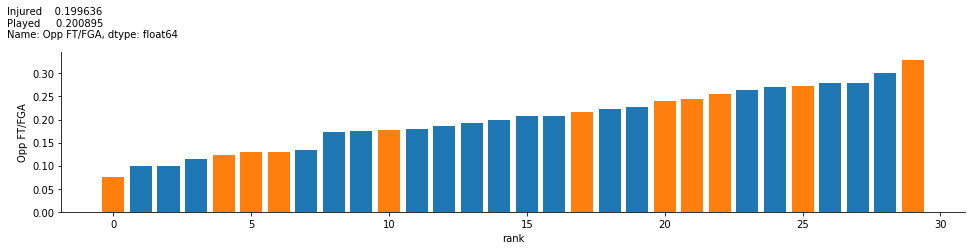

In [137]:
plot_all_stats(curry, 2019)

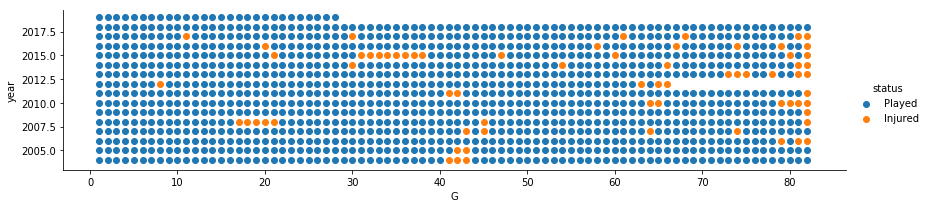

In [101]:
lebron_james = get_game_log('LeBron James', start_year=2003)
plot_viz(lebron_james)

status
Injured    13
Played     69
Name: G, dtype: int64 



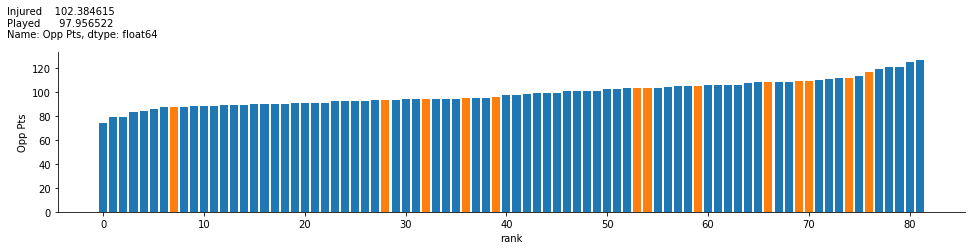

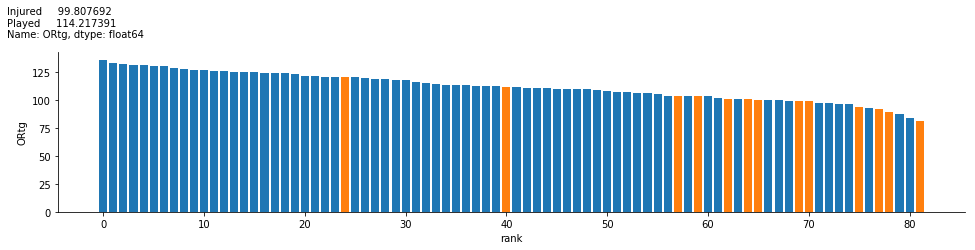

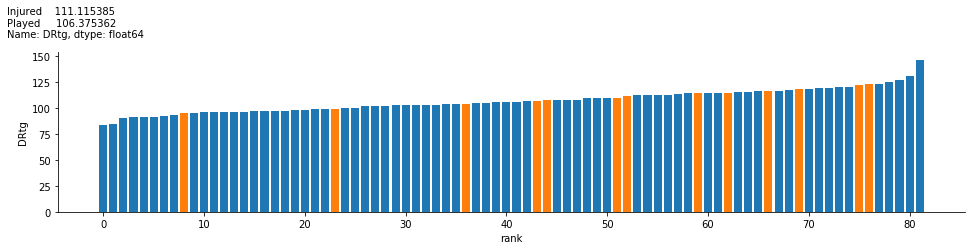

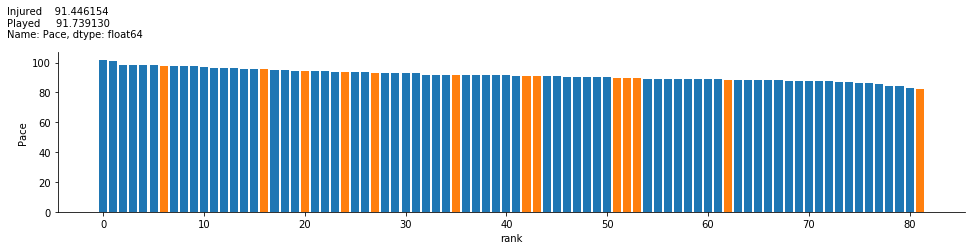

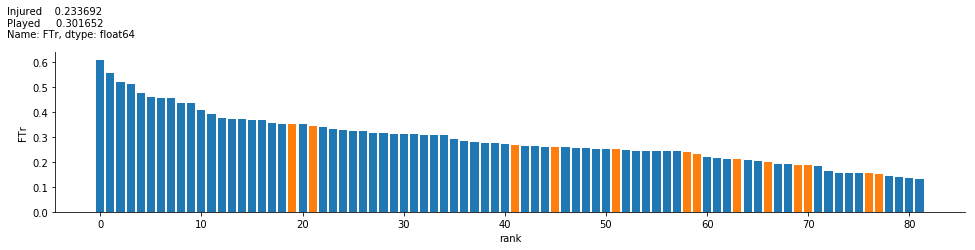

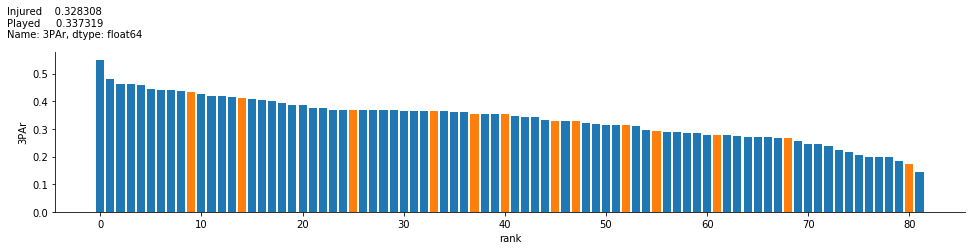

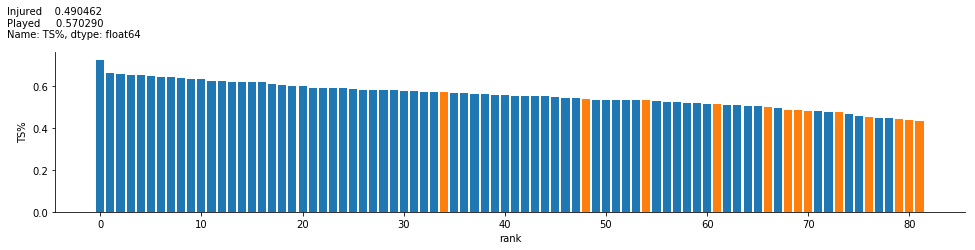

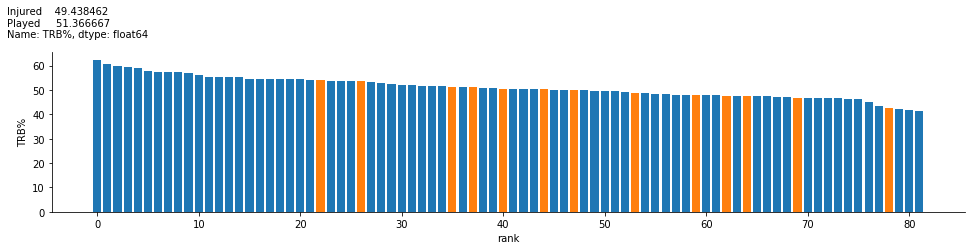

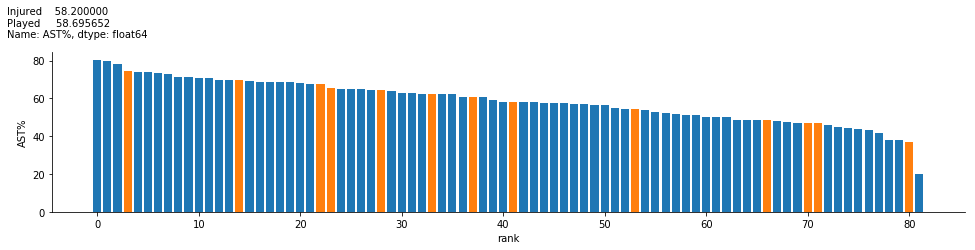

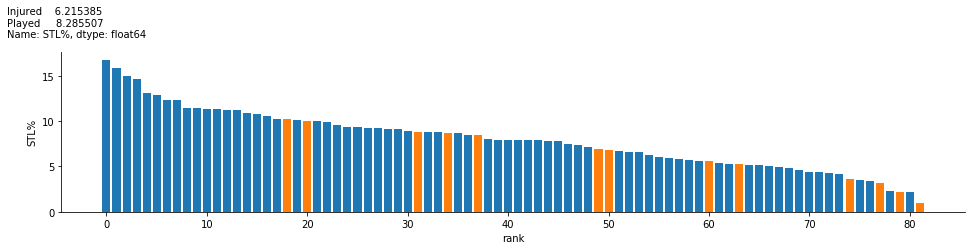

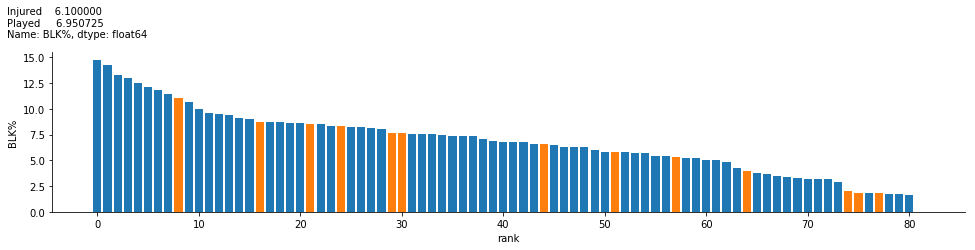

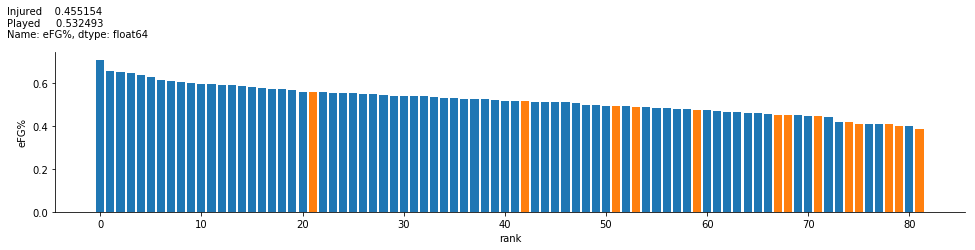

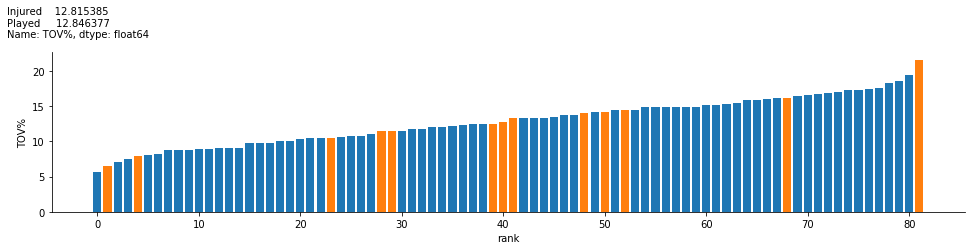

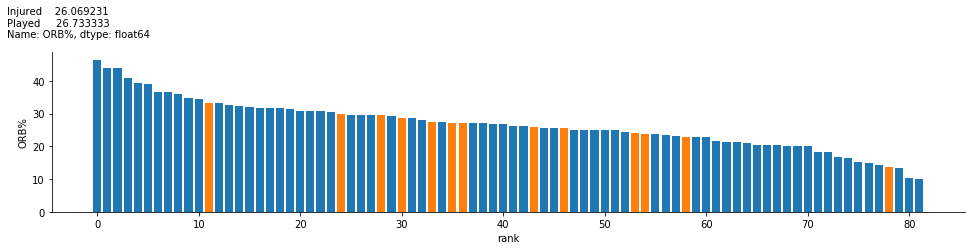

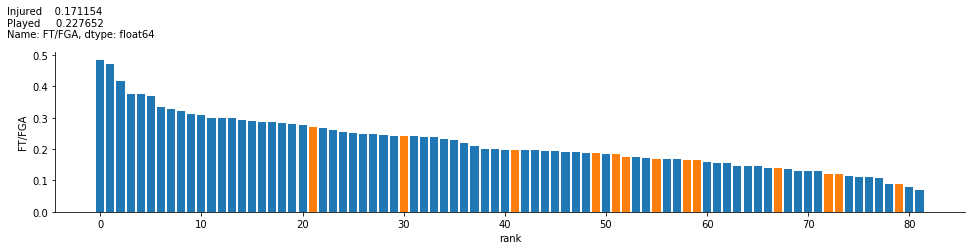

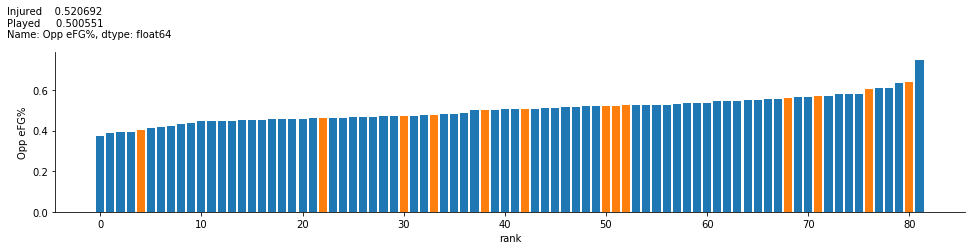

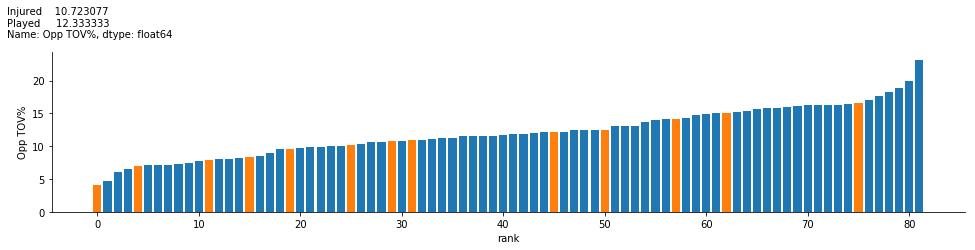

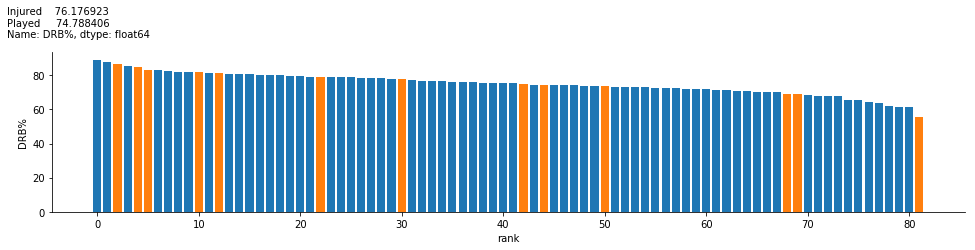

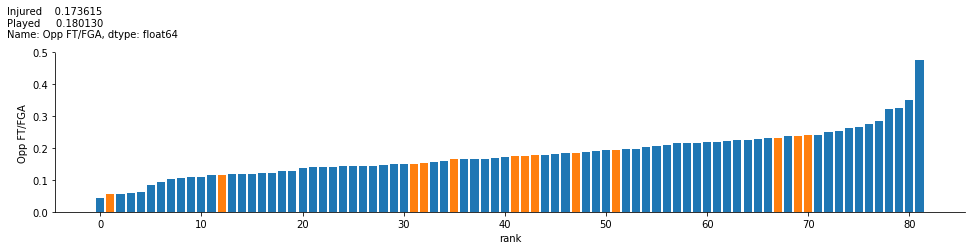

In [140]:
plot_all_stats(lebron_james, 2015)

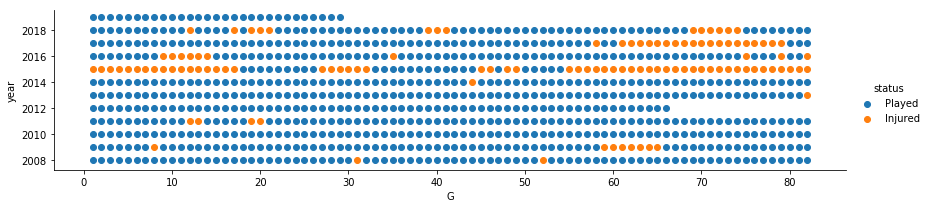

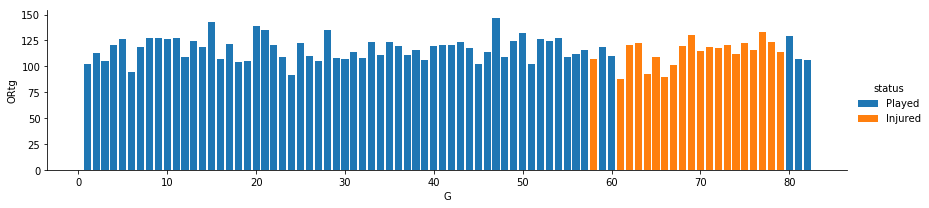

In [36]:
kd = get_game_log('Kevin Durant', start_year=2006)
plot_viz(kd)
plot_stat(kd, 2017, 'ORtg')


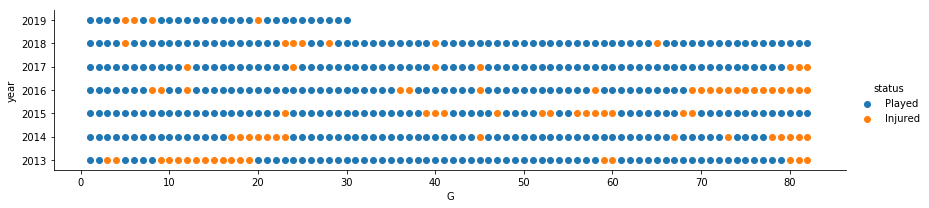

In [31]:
ad = get_game_log('Anthony Davis', start_year=2012)
plot_viz(ad)

status
Injured     4
Played     26
Name: G, dtype: int64 



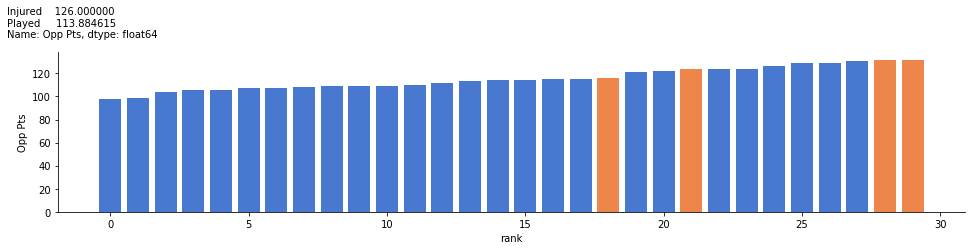

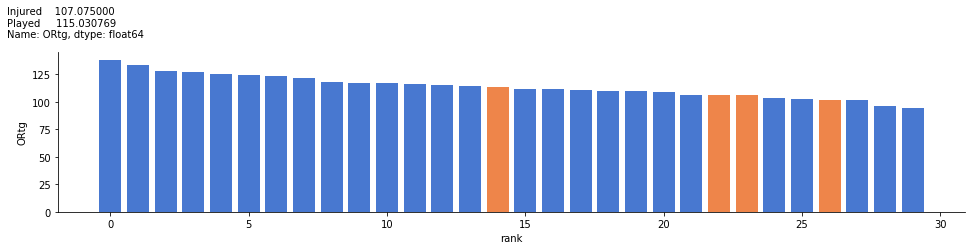

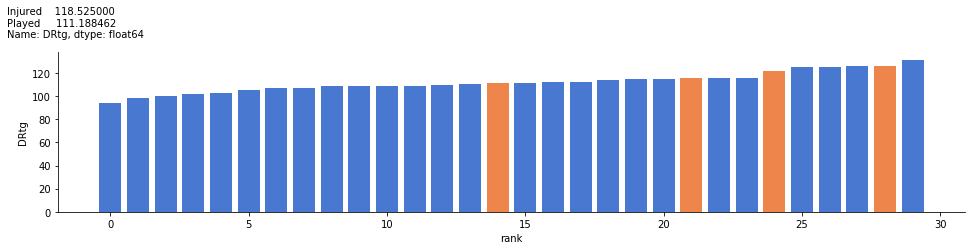

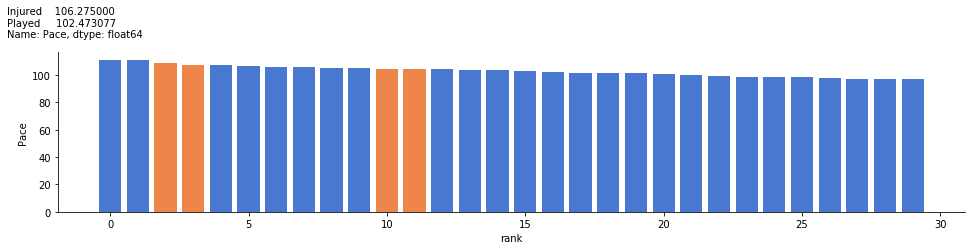

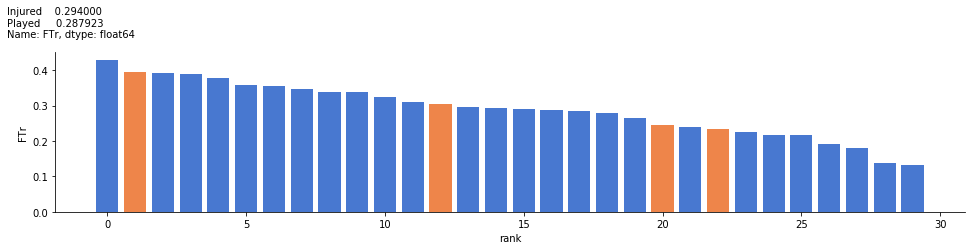

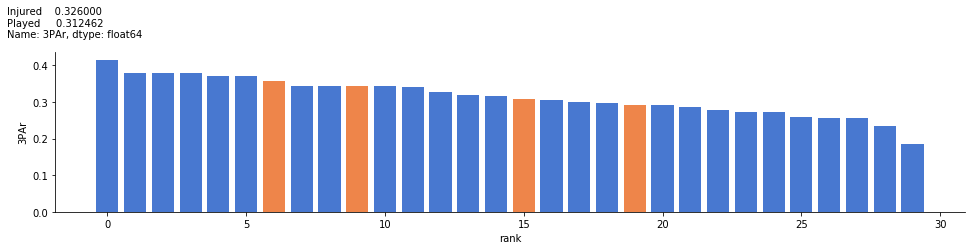

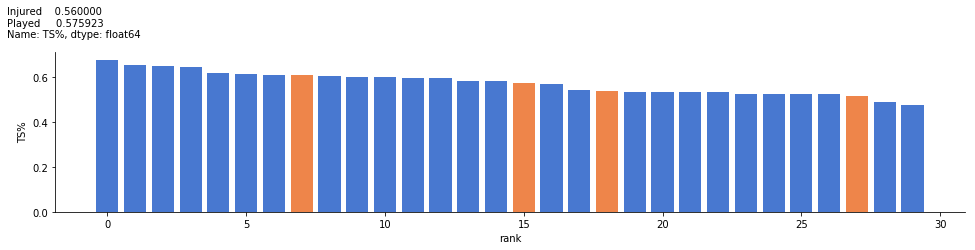

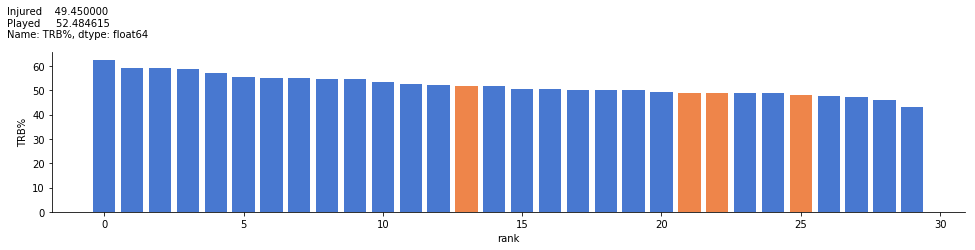

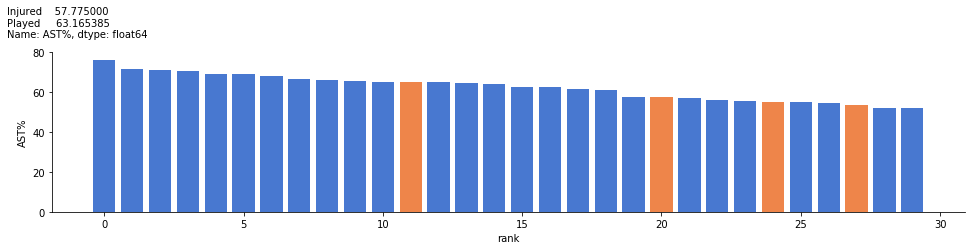

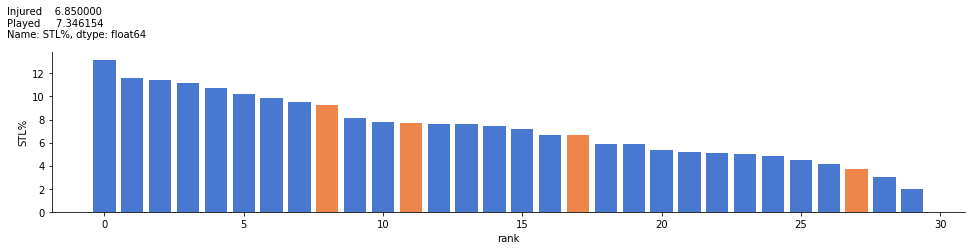

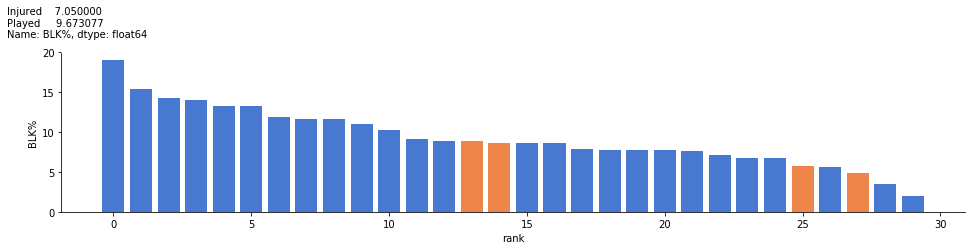

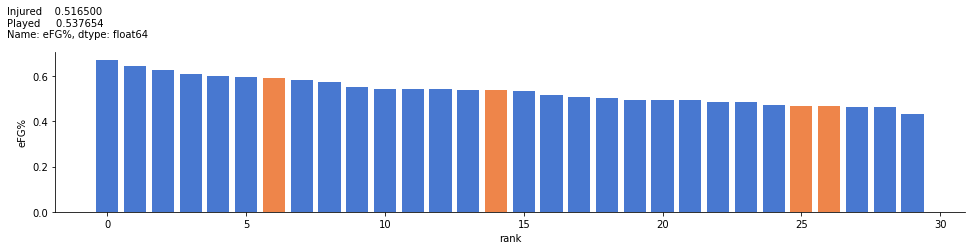

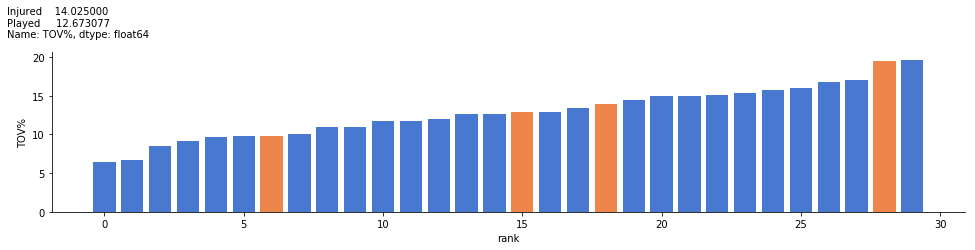

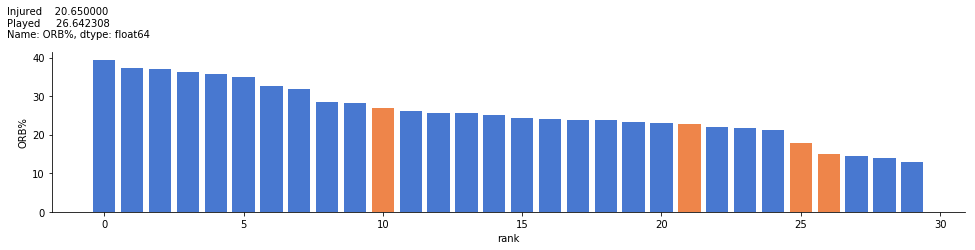

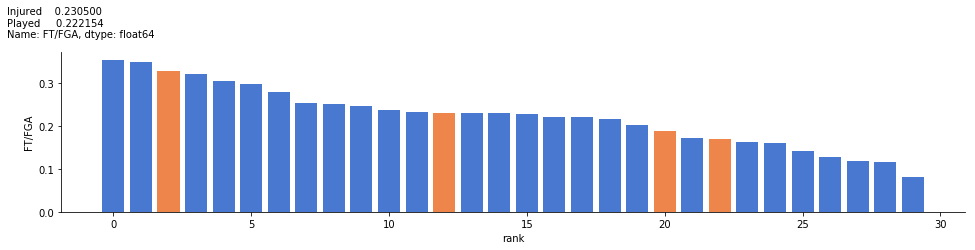

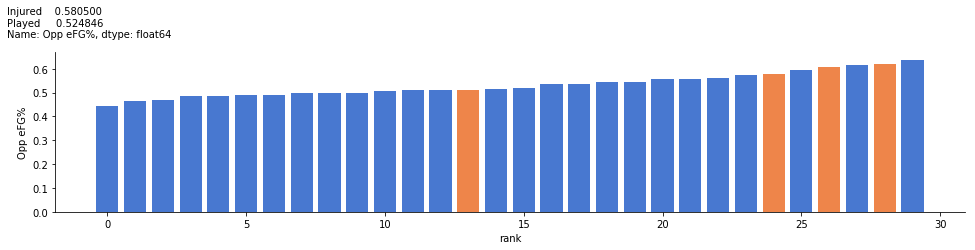

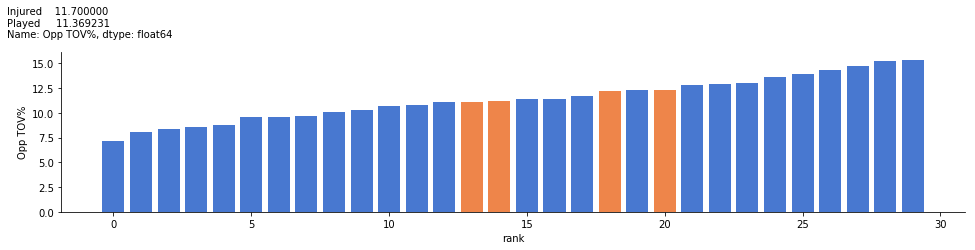

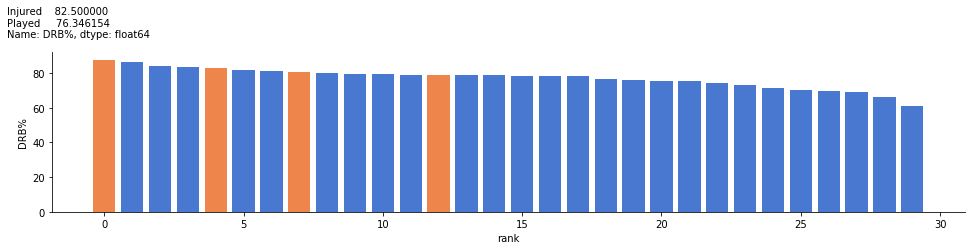

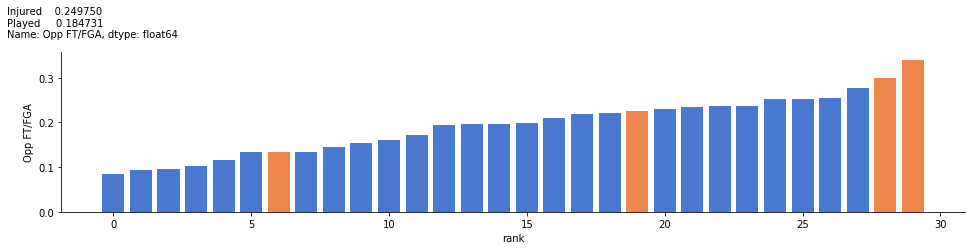

In [163]:
plot_all_stats(ad, 2019)

In [29]:
harden = get_game_log('James Harden', start_year=2009)

status
Injured    10
Played     72
Name: G, dtype: int64 



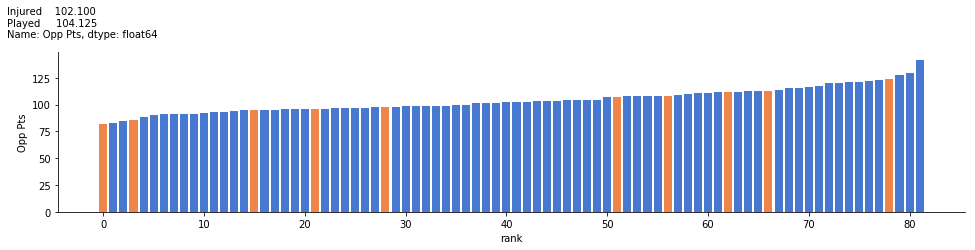

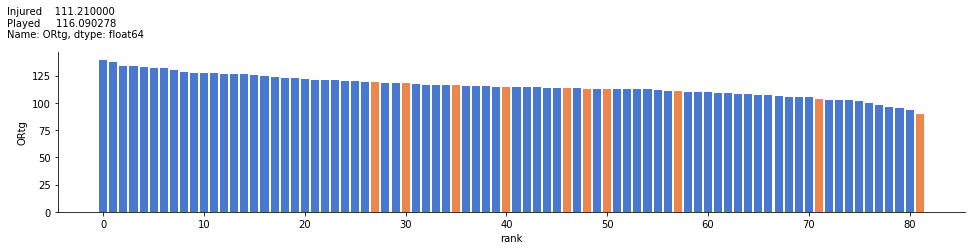

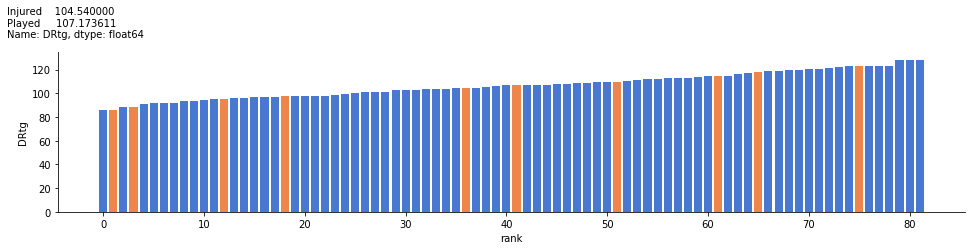

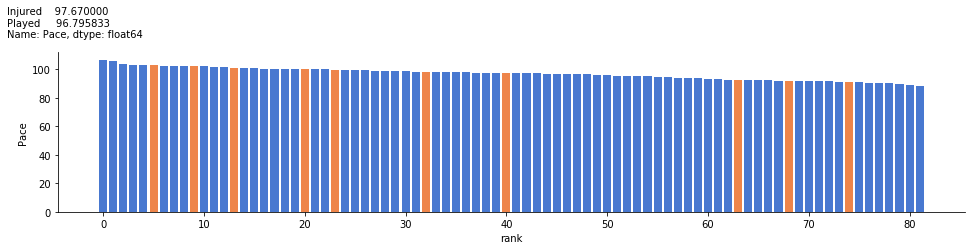

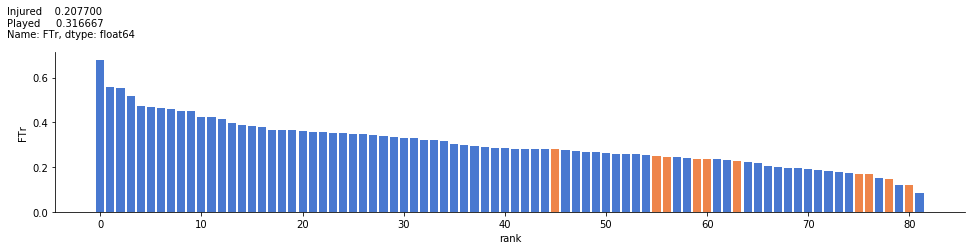

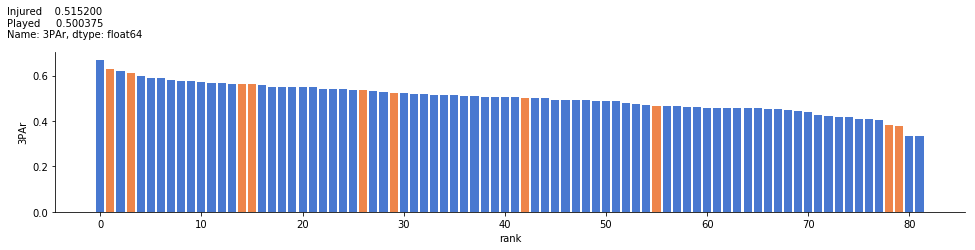

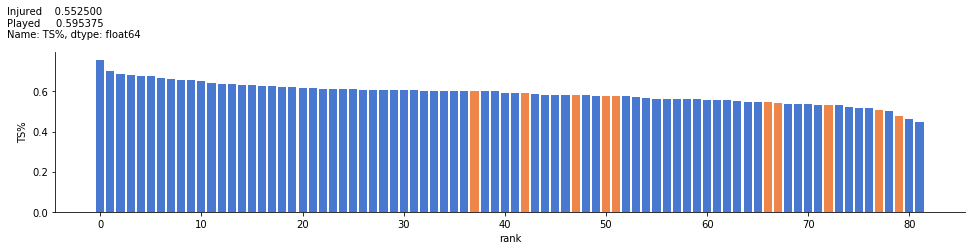

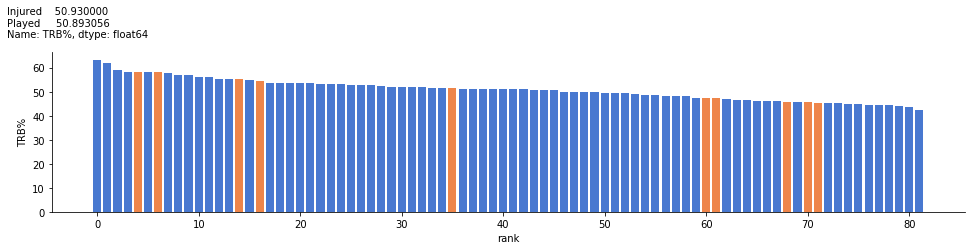

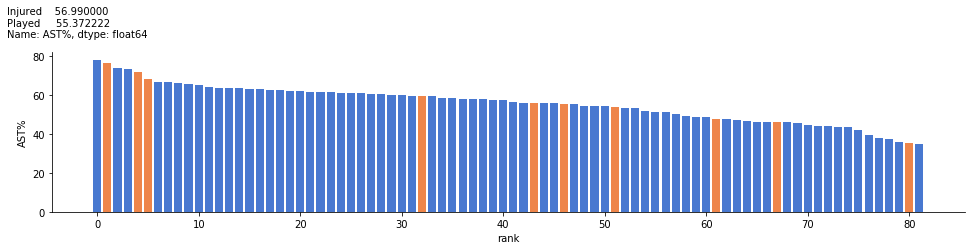

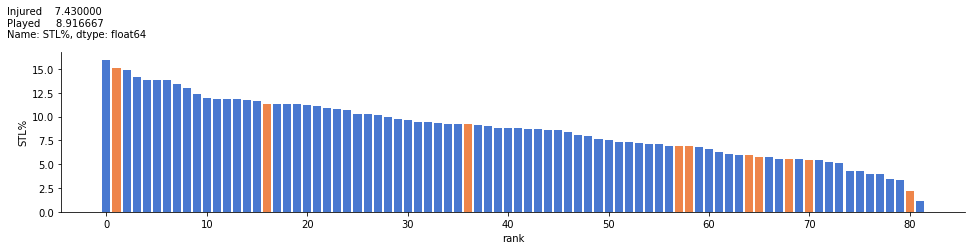

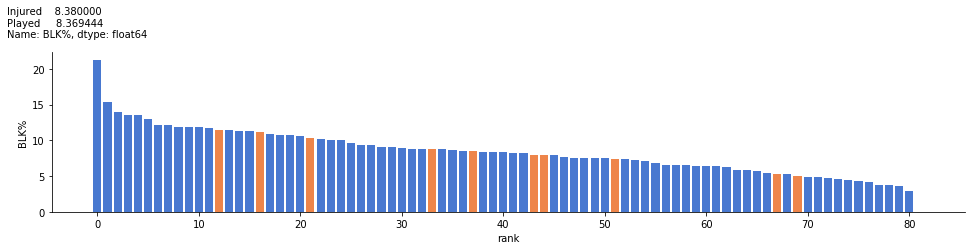

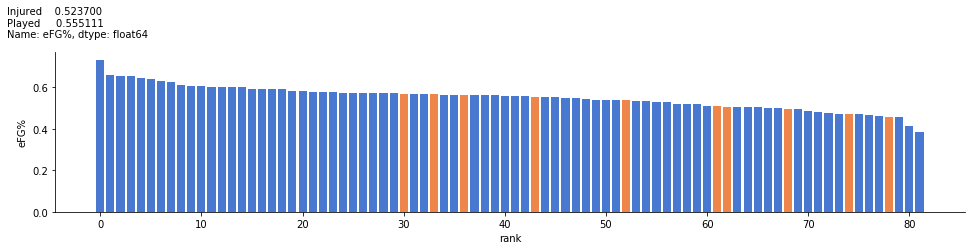

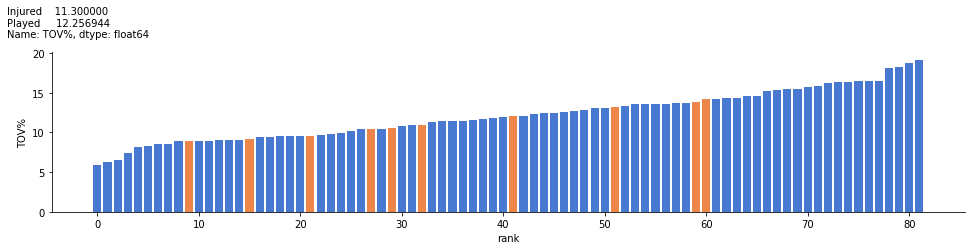

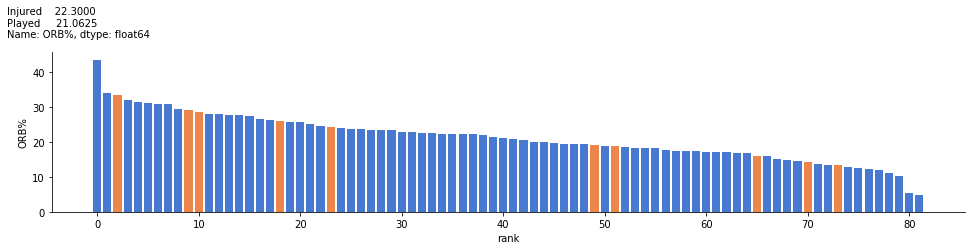

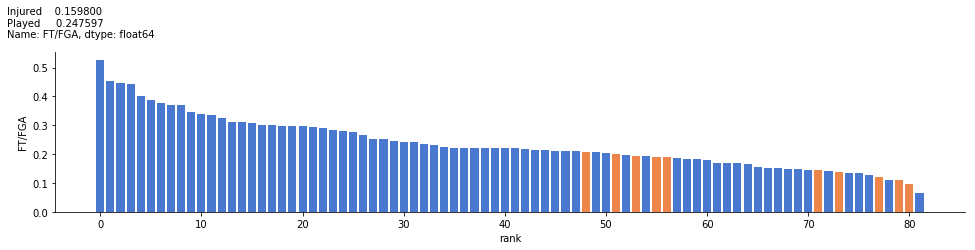

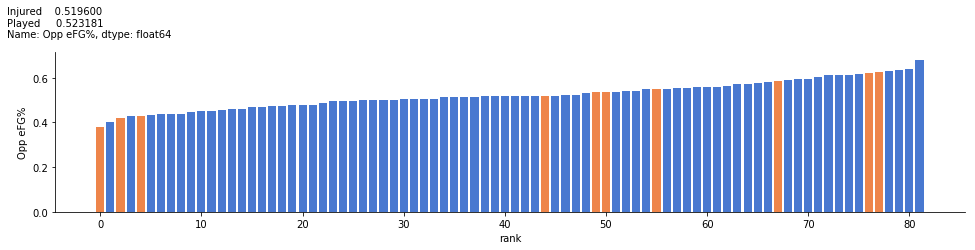

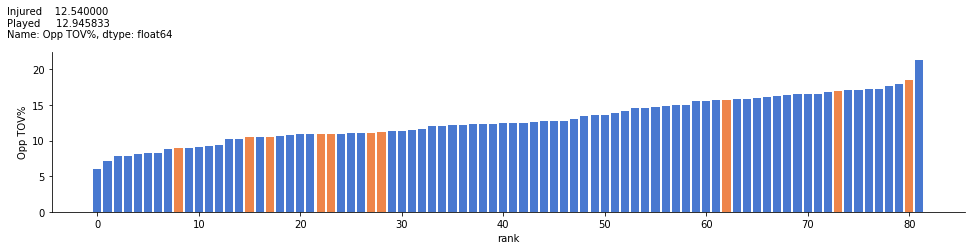

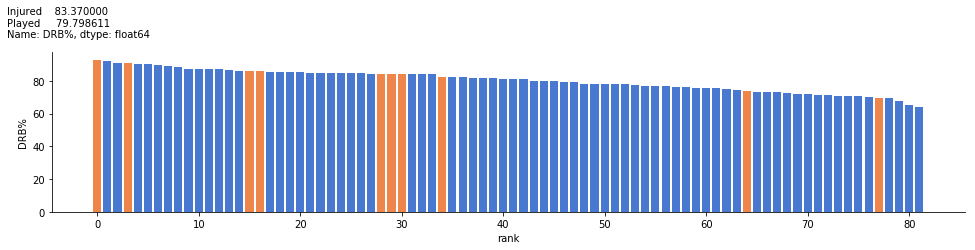

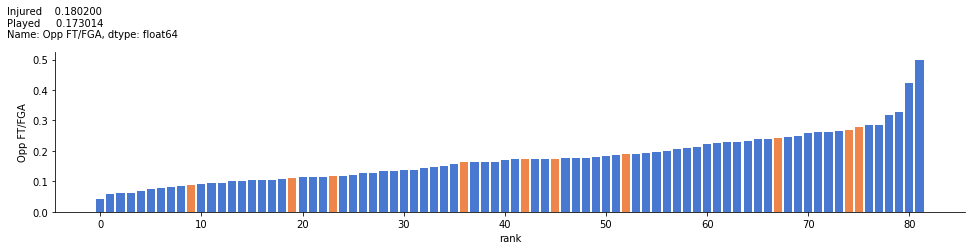

In [153]:
plot_all_stats(harden, 2018)

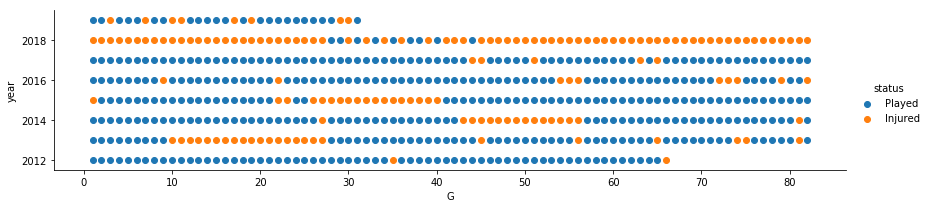

In [157]:
kawhi = get_game_log('Kawhi Leonard', start_year=2010)
plot_viz(kawhi)

status
Injured     8
Played     23
Name: G, dtype: int64 



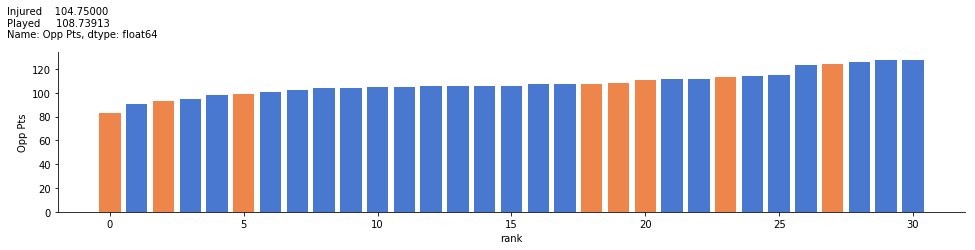

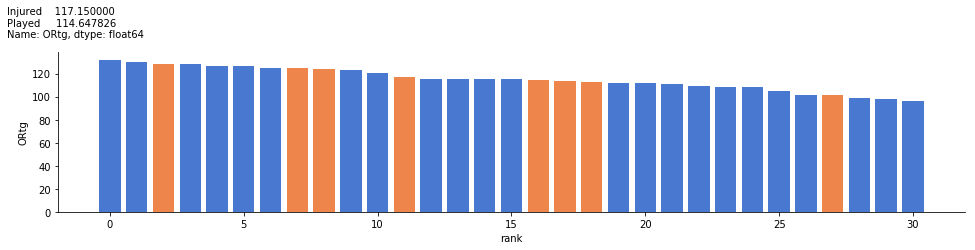

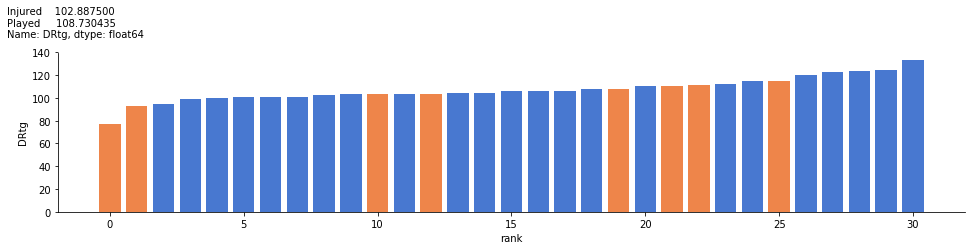

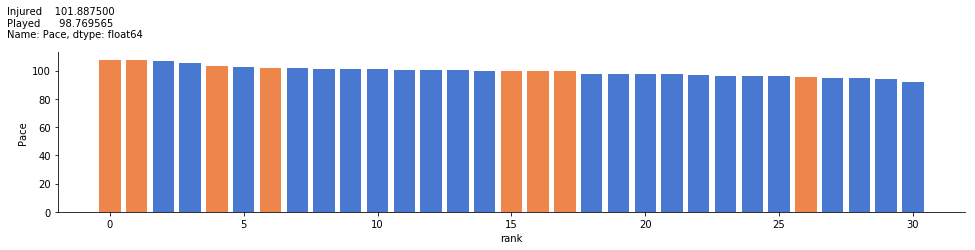

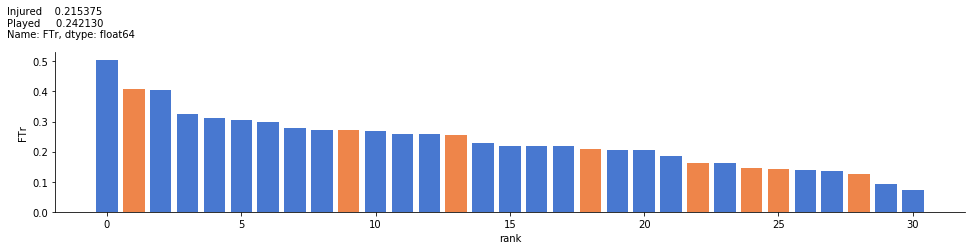

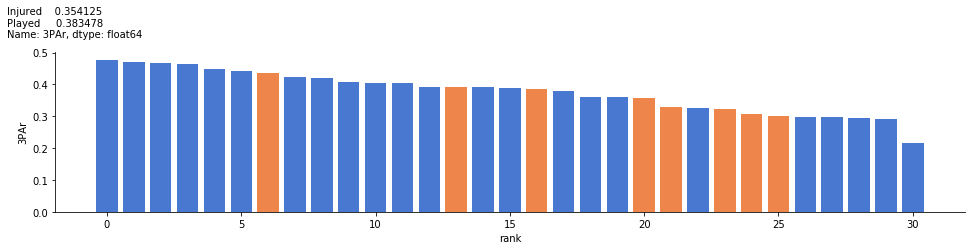

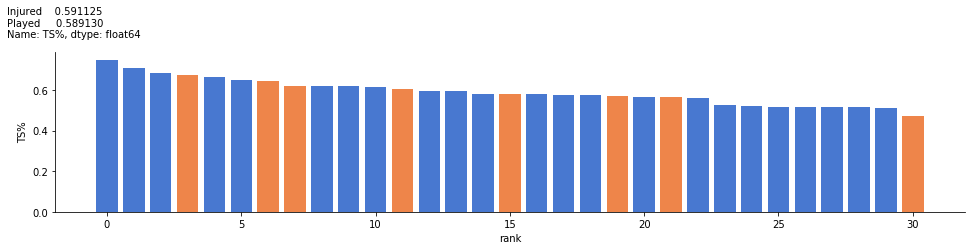

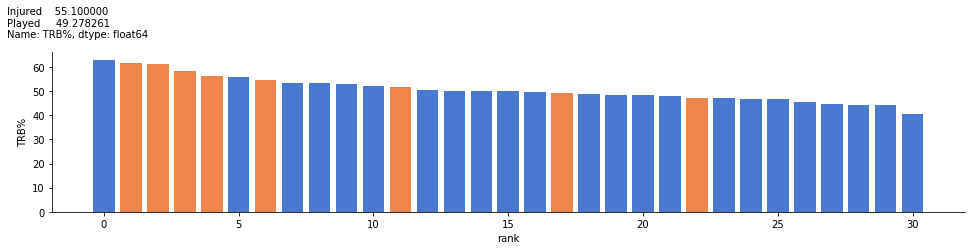

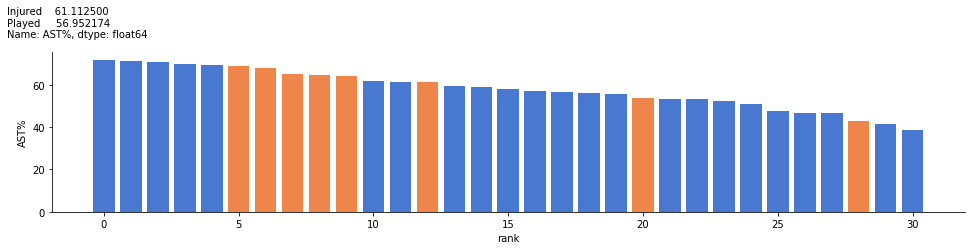

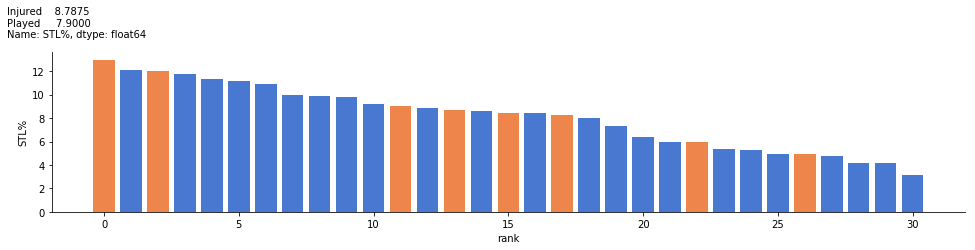

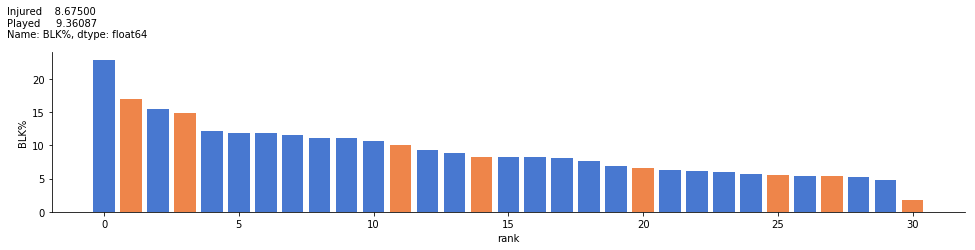

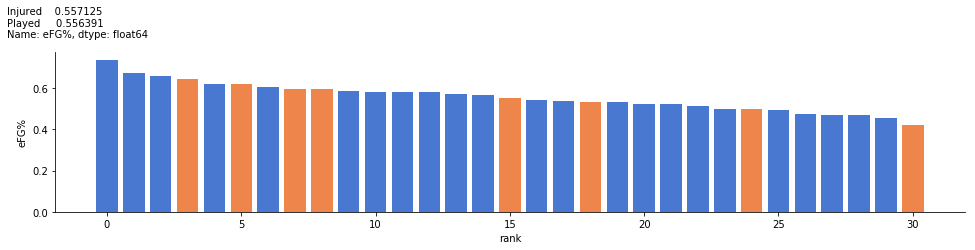

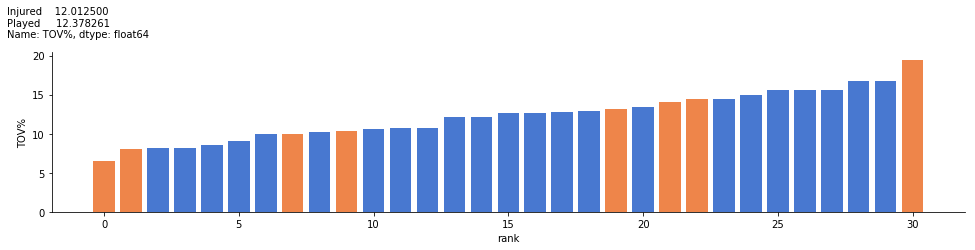

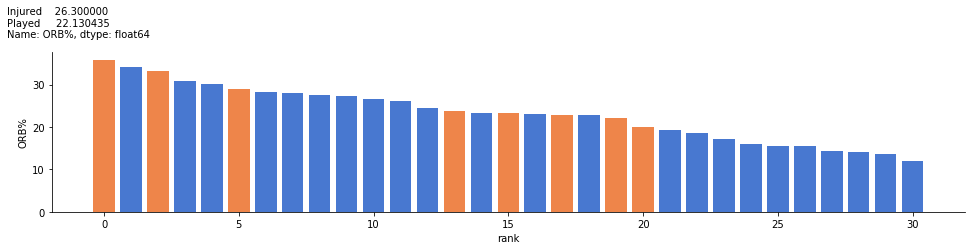

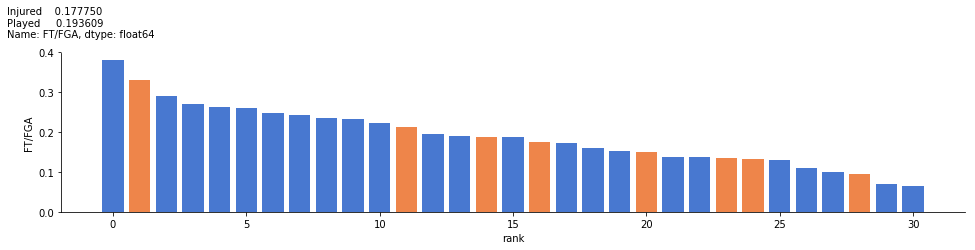

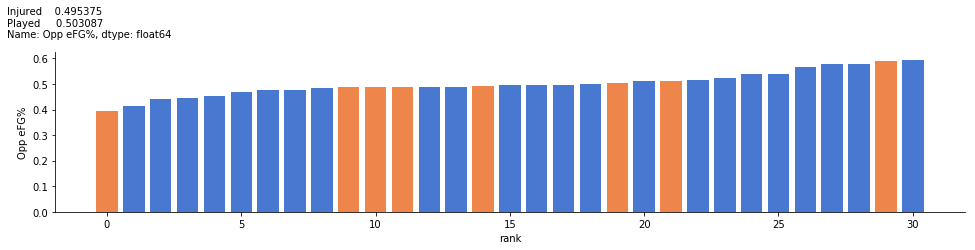

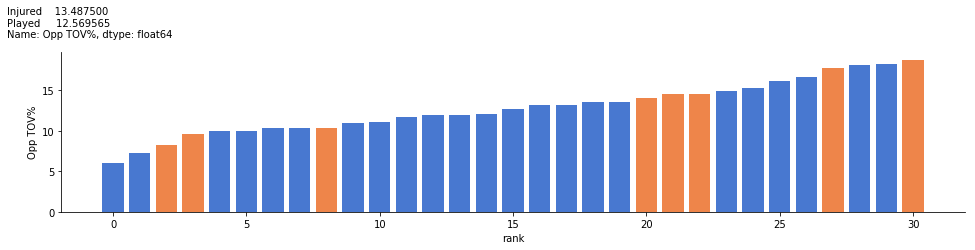

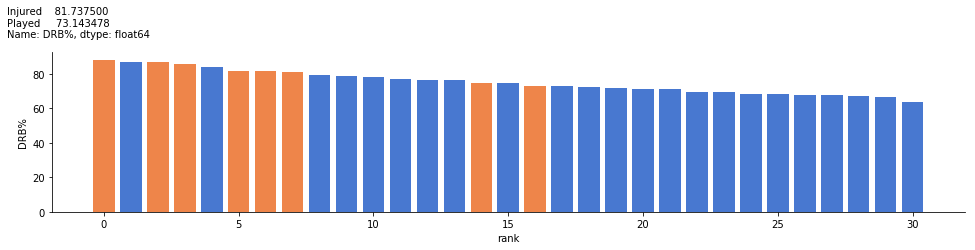

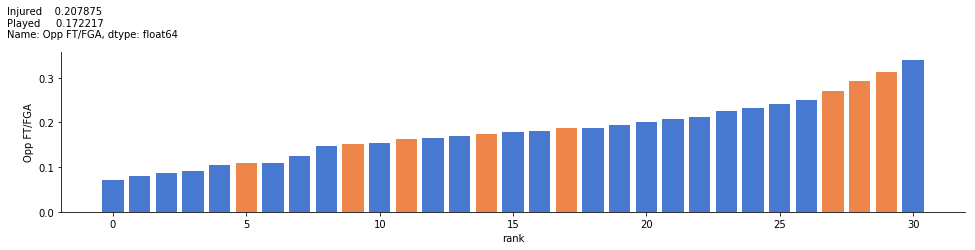

In [158]:
plot_all_stats(kawhi, 2019)

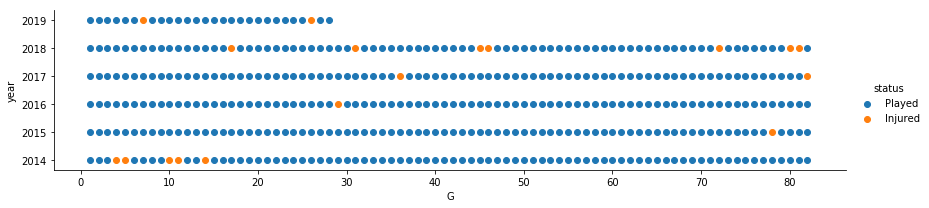

In [160]:
giannis = get_game_log('Giannis Antetokounmpo', start_year=2012)
plot_viz(giannis)

status
Injured     7
Played     75
Name: G, dtype: int64 



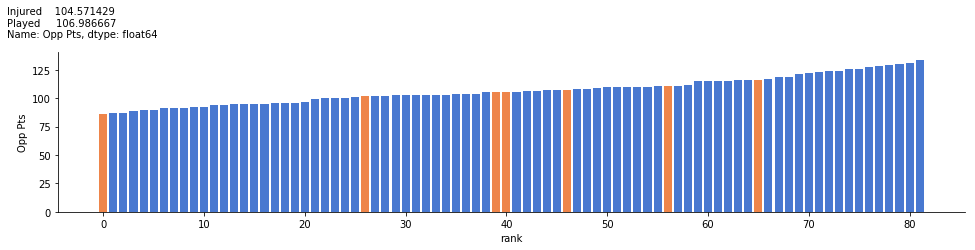

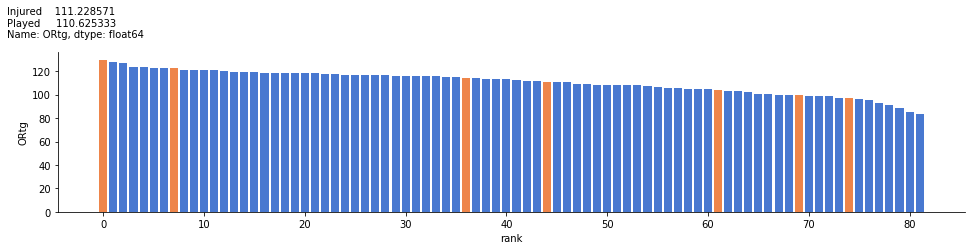

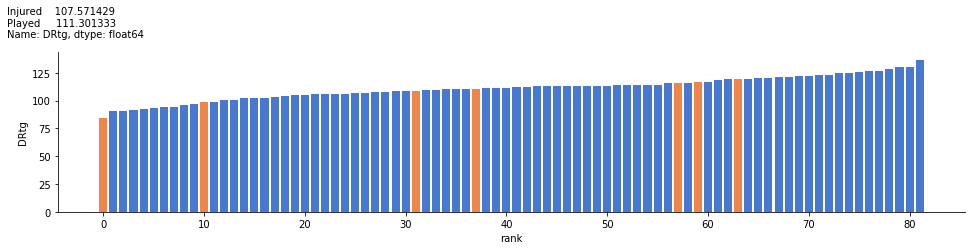

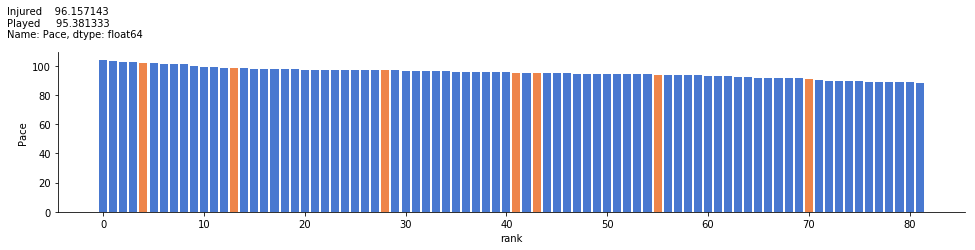

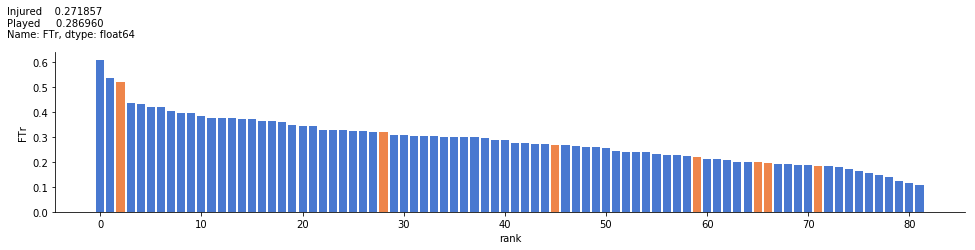

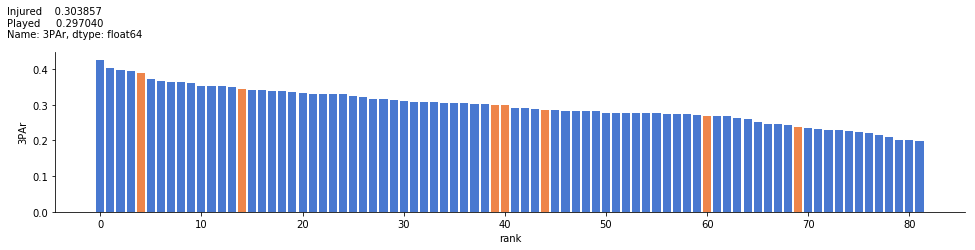

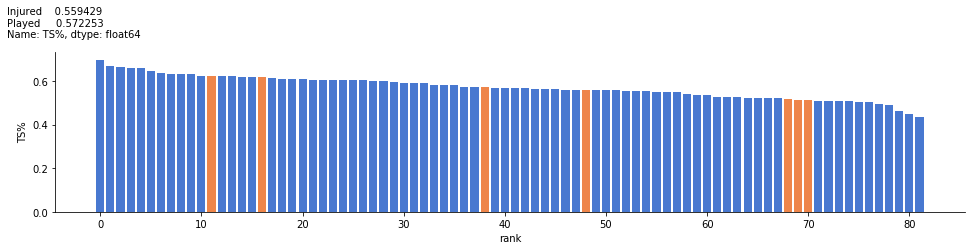

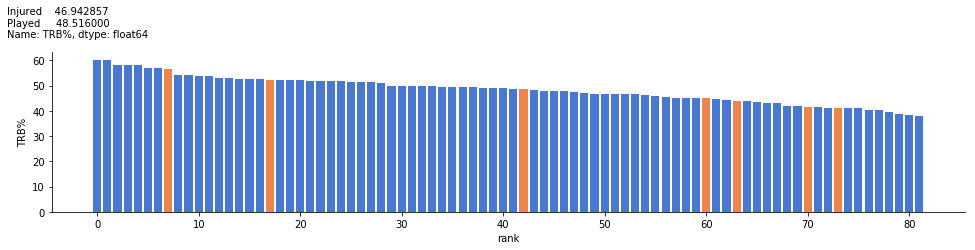

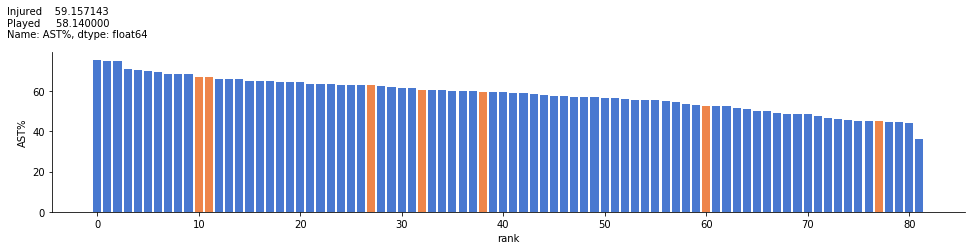

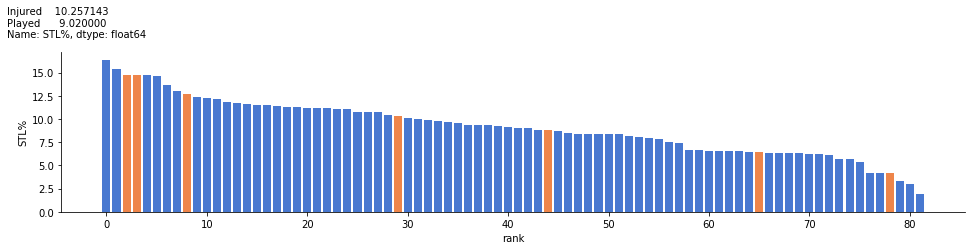

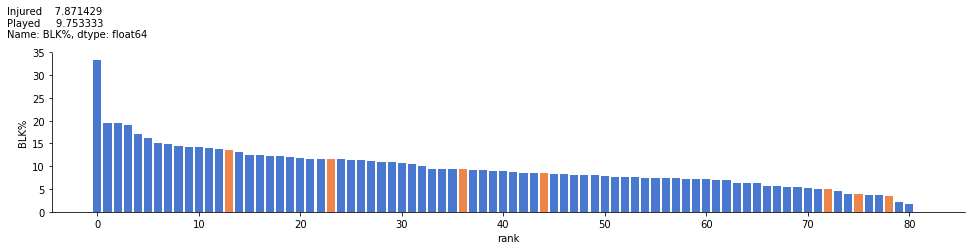

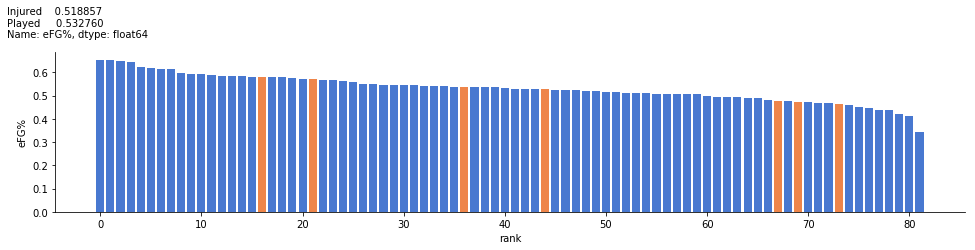

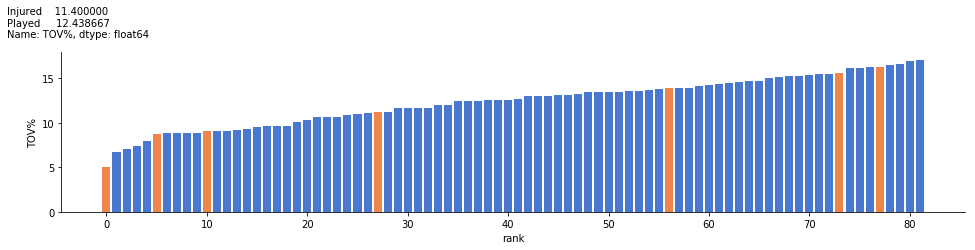

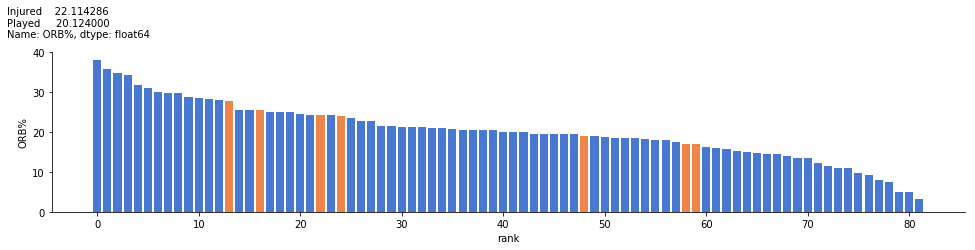

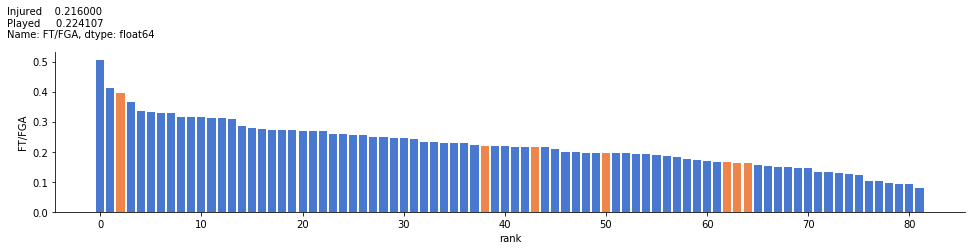

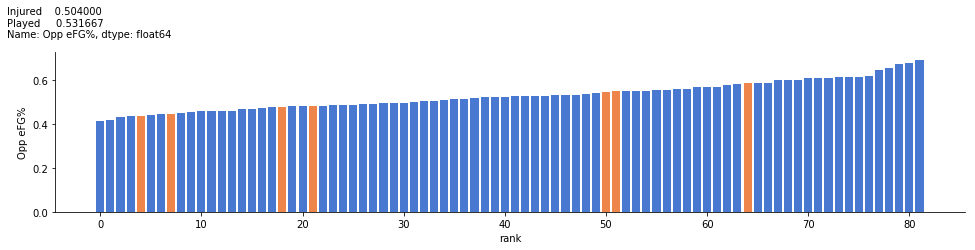

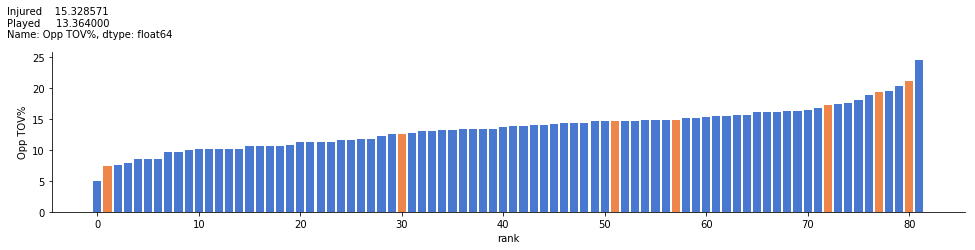

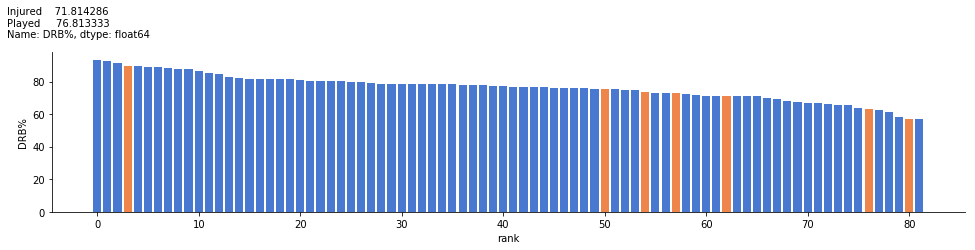

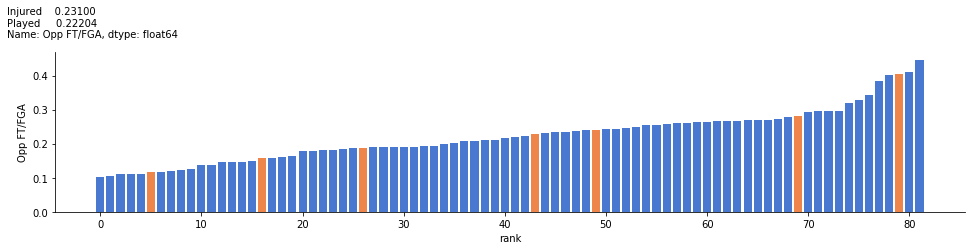

In [162]:
plot_all_stats(giannis, 2018)

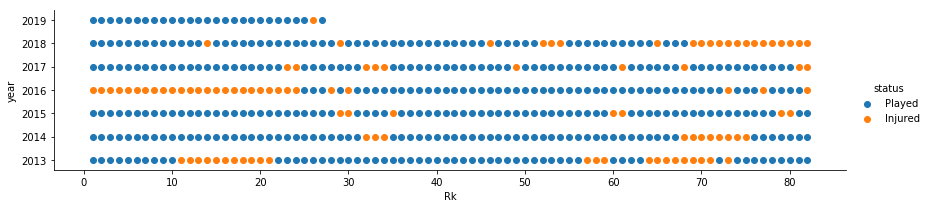

In [27]:
plot_viz(get_game_log('Kyrie Irving', start_year=2013))

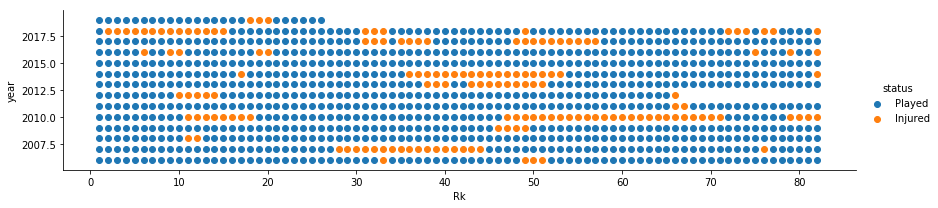

In [33]:
plot_viz(get_game_log('Chris Paul', start_year=2003))

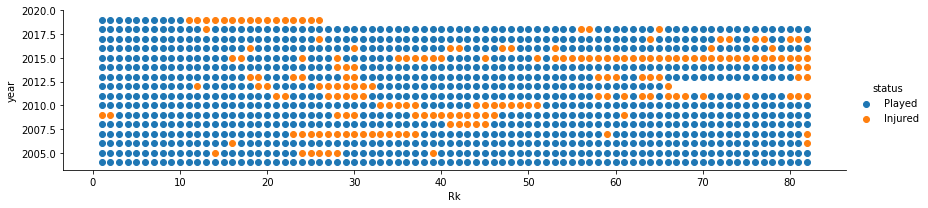

In [30]:
plot_viz(get_game_log('Carmelo Anthony', start_year=2003))

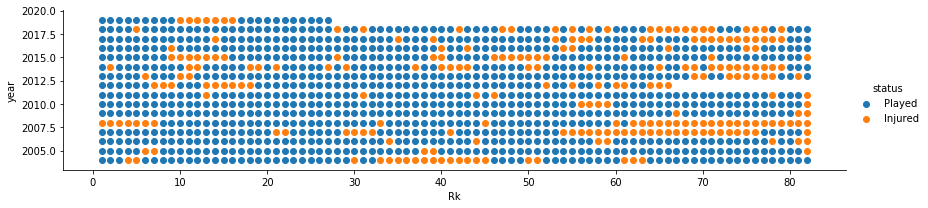

In [31]:
plot_viz(get_game_log('Dwyane Wade', start_year=2003))

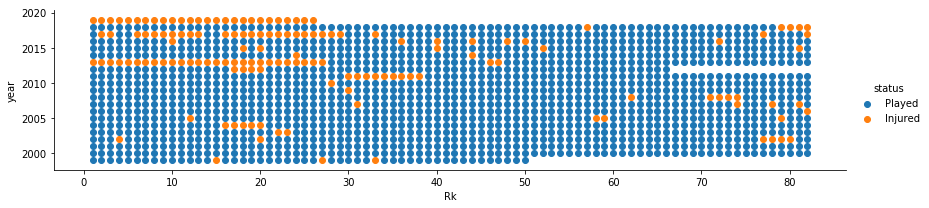

In [34]:
plot_viz(get_game_log('Dirk Nowitzki', start_year=1998))

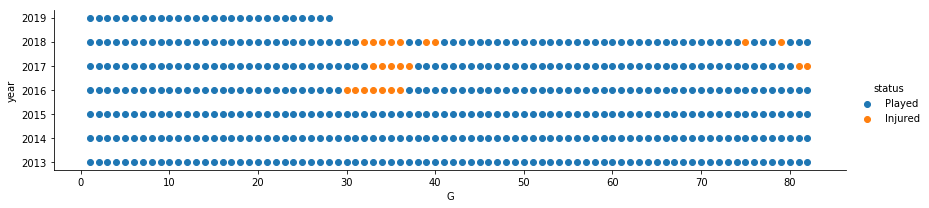

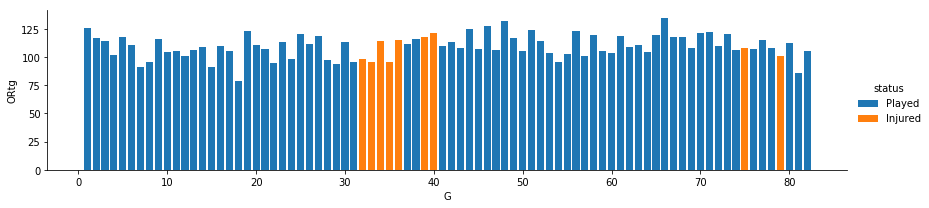

In [38]:
lillard = get_game_log('Damian Lillard', start_year=2008)
plot_viz(lillard)
plot_stat(lillard, 2018, 'ORtg')

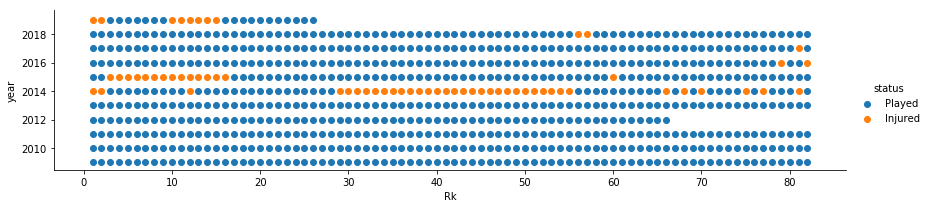

In [42]:
plot_viz(get_game_log('Russell Westbrook', start_year=2006))

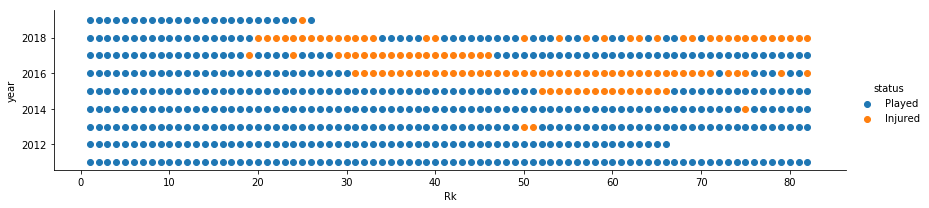

In [46]:
plot_viz(get_game_log('Blake Griffin', start_year=2007))

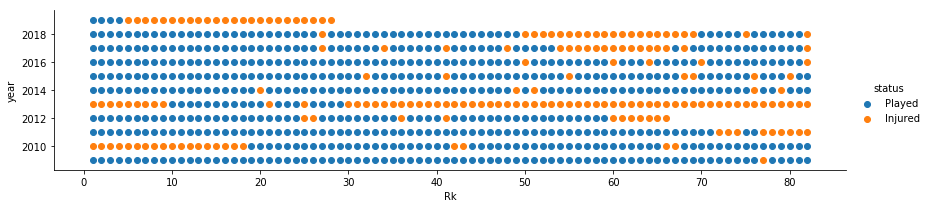

In [43]:
plot_viz(get_game_log('Kevin Love', start_year=2008))

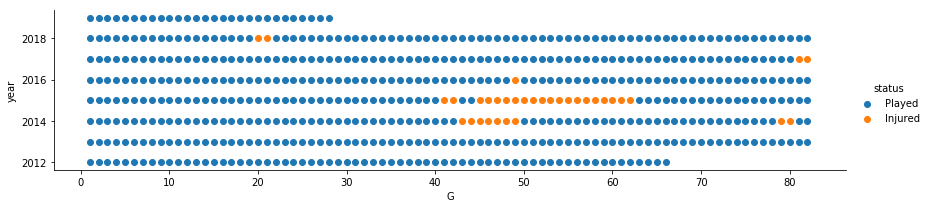

In [69]:
kemba = get_game_log('Kemba Walker', start_year=2011)
plot_viz(kemba)

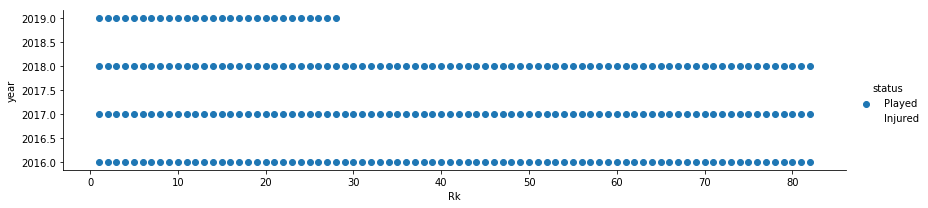

In [50]:
plot_viz(get_game_log('Karl Anthony Towns', start_year=2014))

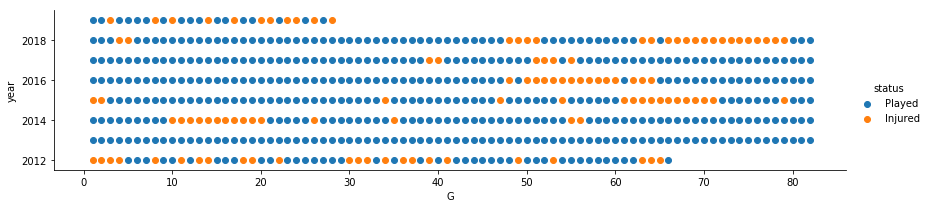

In [164]:
jb = get_game_log('Jimmy Butler', start_year=2009)
plot_viz(jb)

status
Injured    22
Played     60
Name: G, dtype: int64 



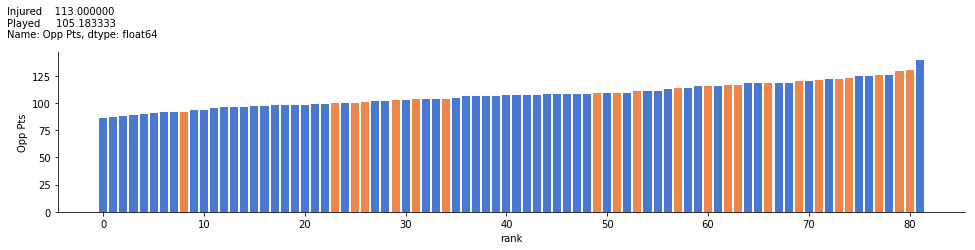

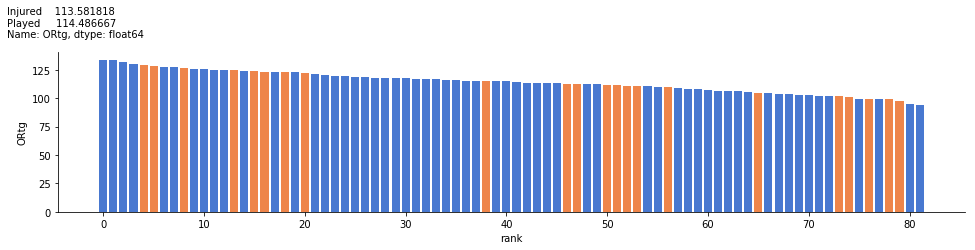

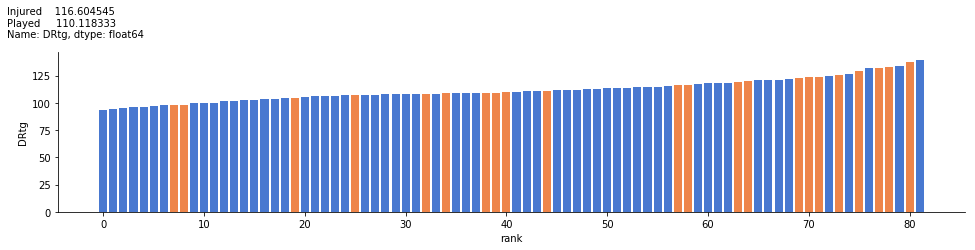

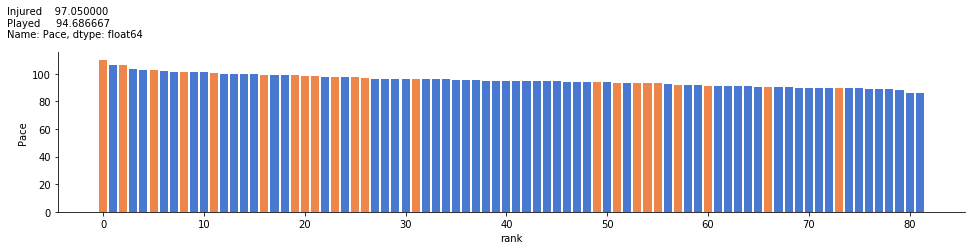

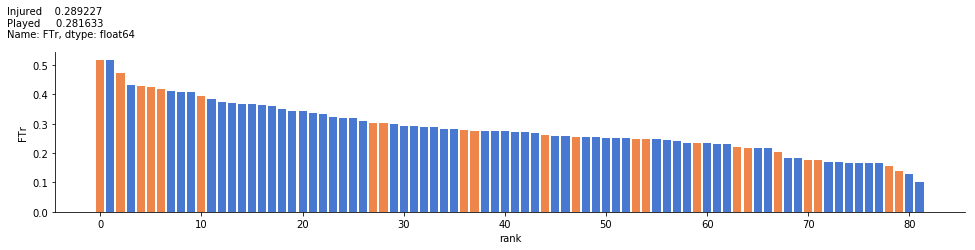

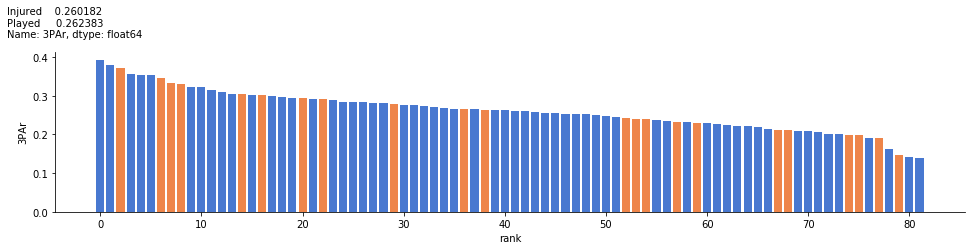

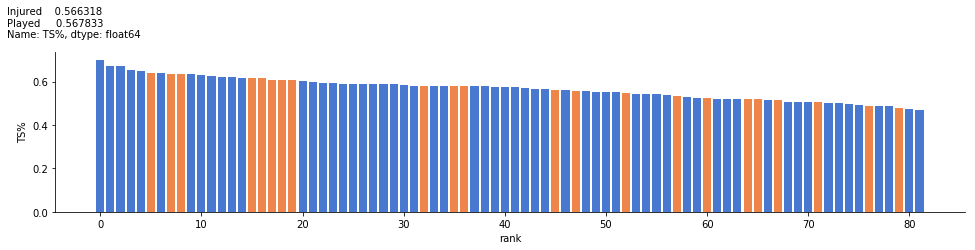

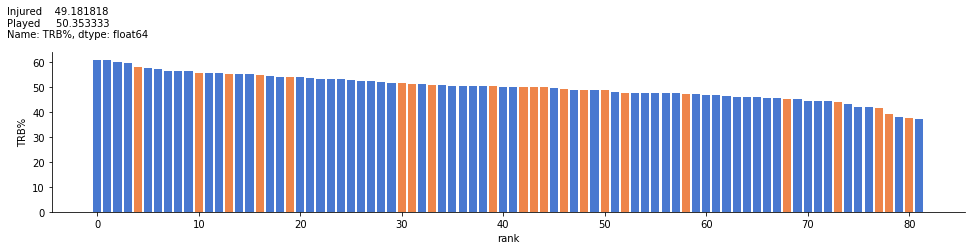

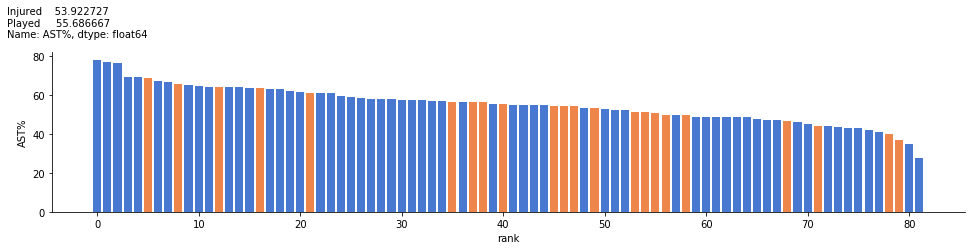

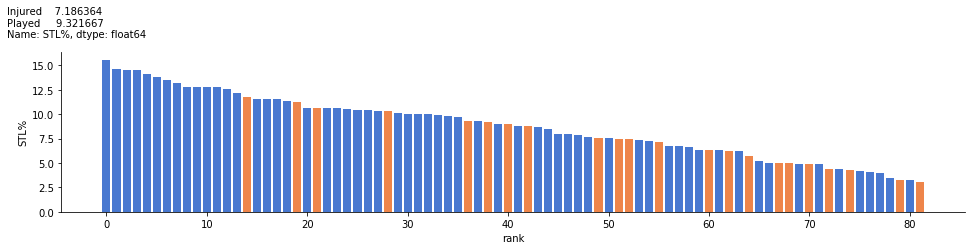

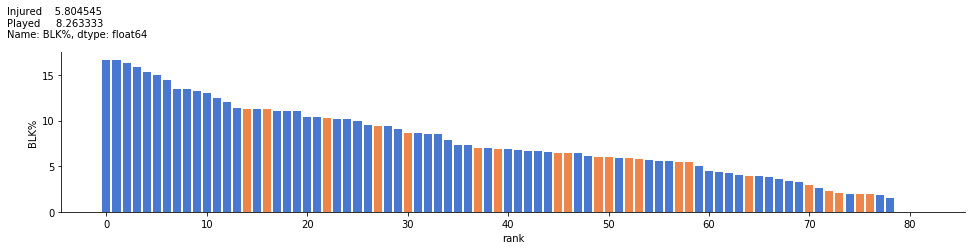

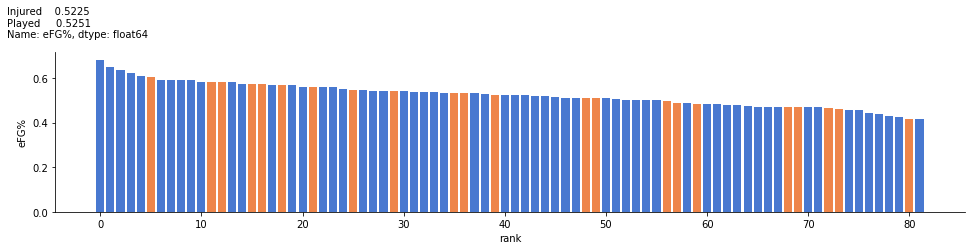

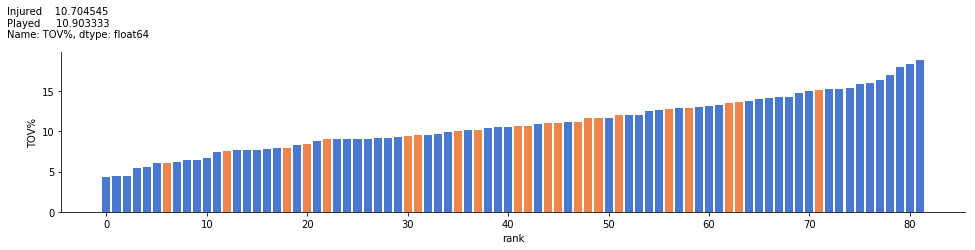

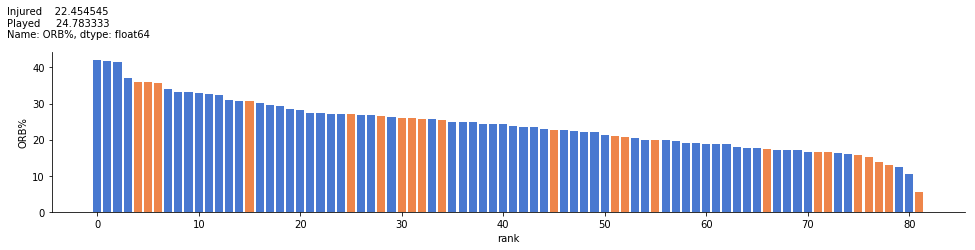

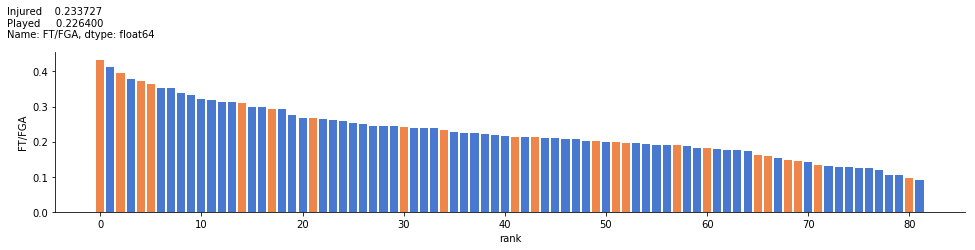

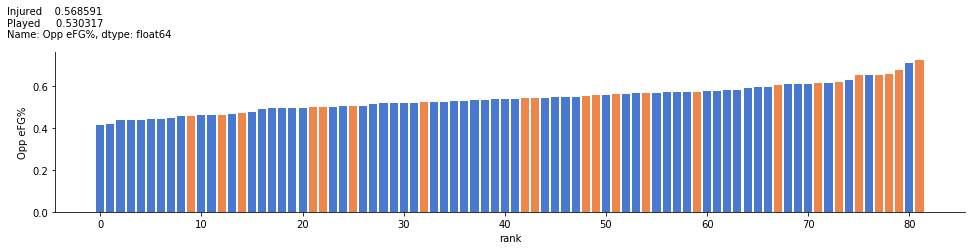

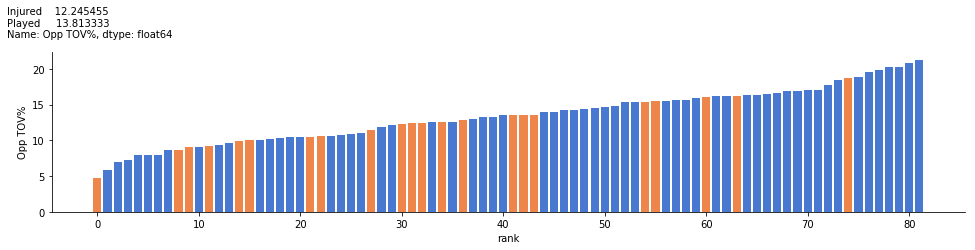

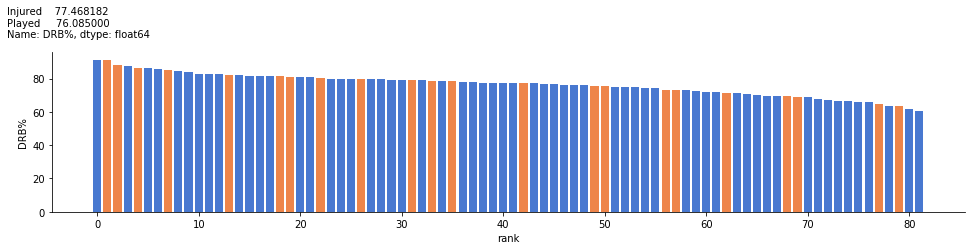

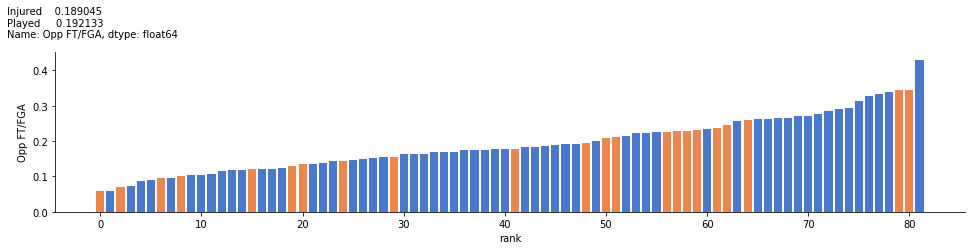

In [165]:
plot_all_stats(jb, 2018)

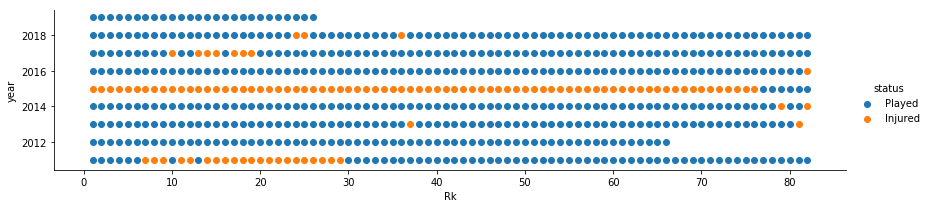

In [47]:
plot_viz(get_game_log('Paul George', start_year=2009))

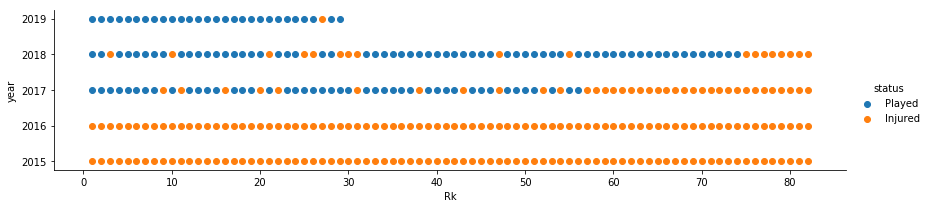

In [37]:
plot_viz(get_game_log('Joel Embiid', start_year=2013))

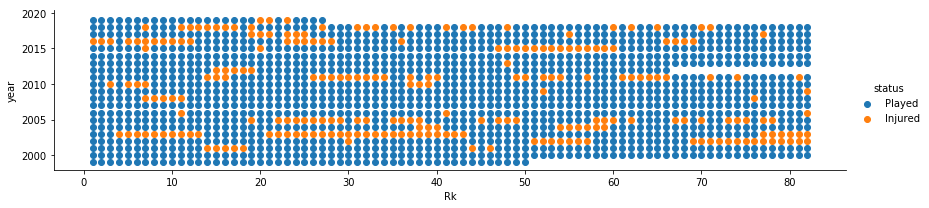

In [38]:
plot_viz(get_game_log('Vince Carter', start_year=1998))

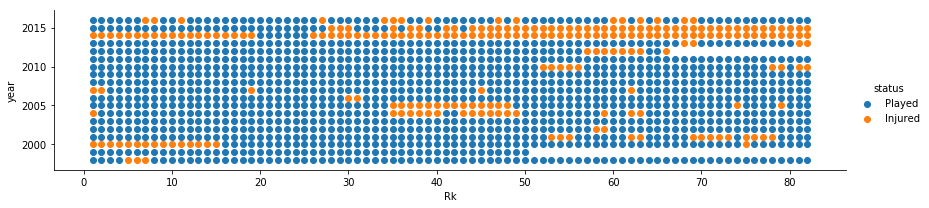

In [40]:
plot_viz(get_game_log('Kobe Bryant', start_year=1998))

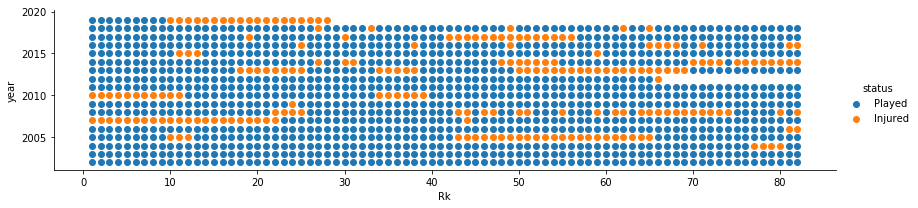

In [48]:
plot_viz(get_game_log('Pau Gasol', start_year=2000))

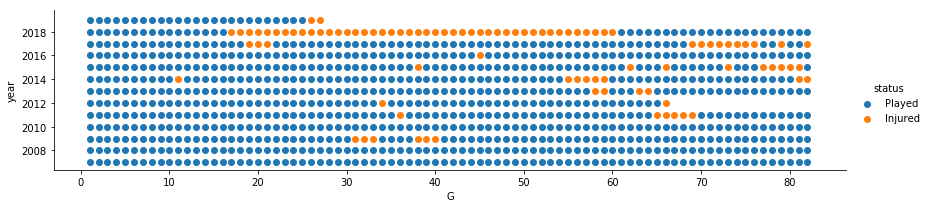

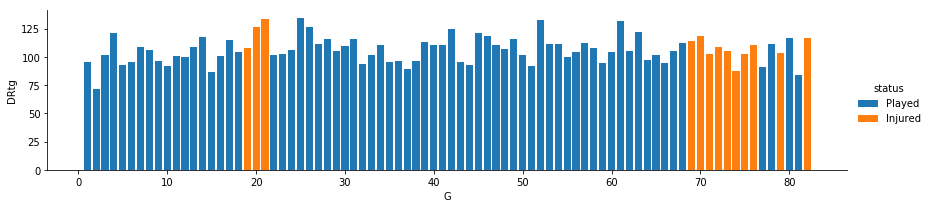

In [23]:
millsap = get_game_log('Paul Millsap', start_year=2005)
plot_viz(millsap)
plot_stat(millsap, 2017, 'DRtg')

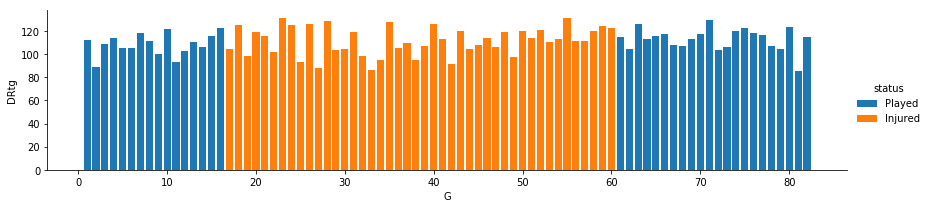

In [25]:
plot_stat(millsap, 2018, 'DRtg')

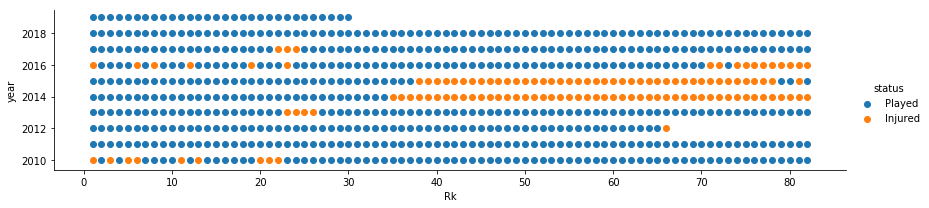

In [11]:
plot_viz(get_game_log('Jrue Holiday', start_year=2010))

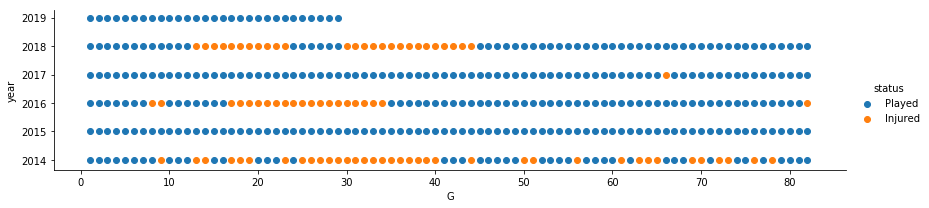

In [23]:
rudy_gobert = get_game_log('Rudy Gobert', start_year=2013)
plot_viz(rudy_gobert)

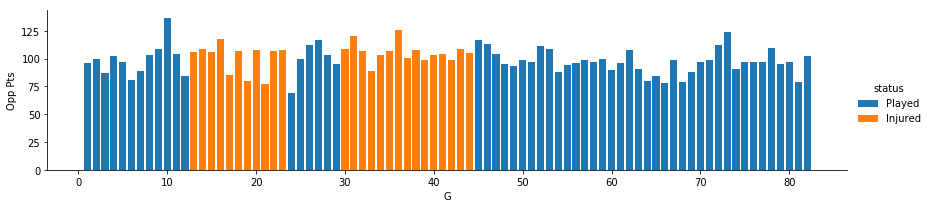

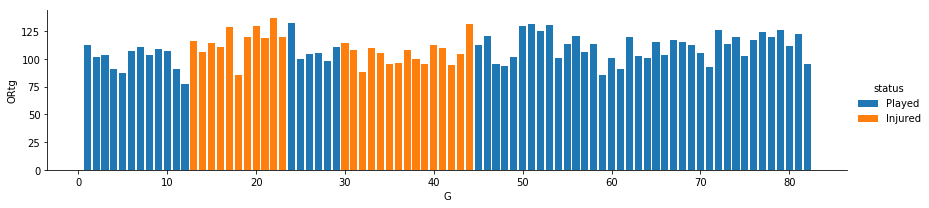

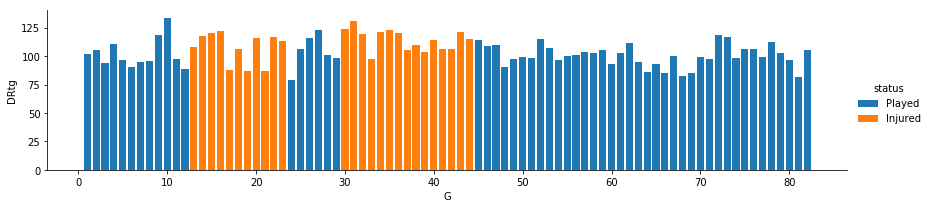

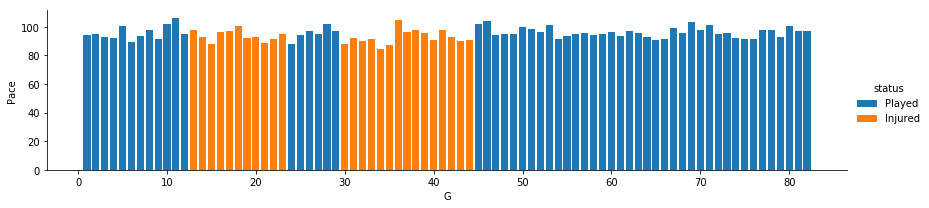

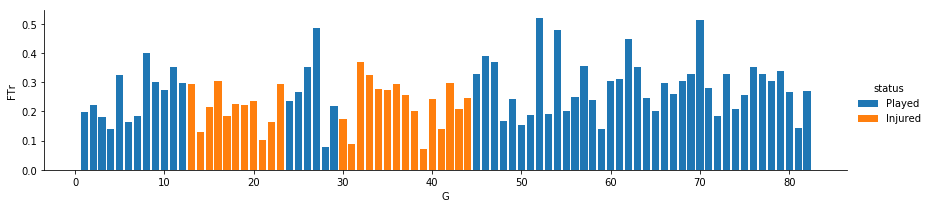

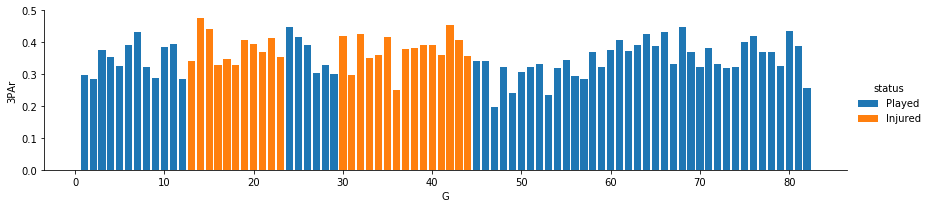

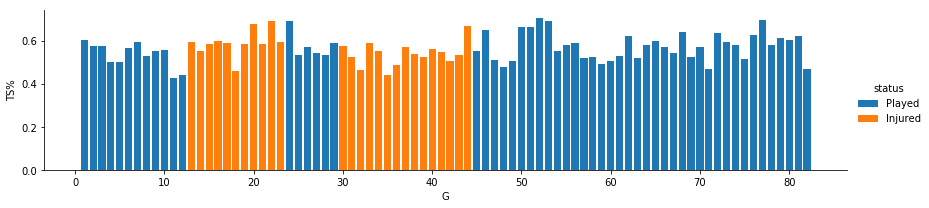

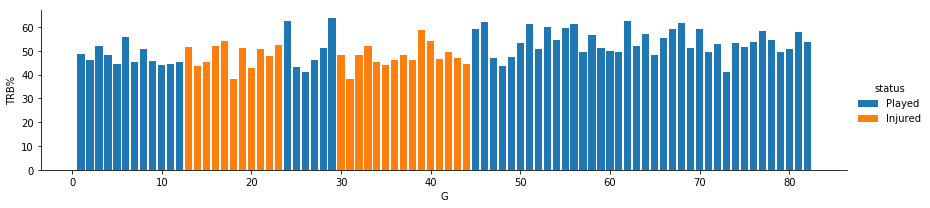

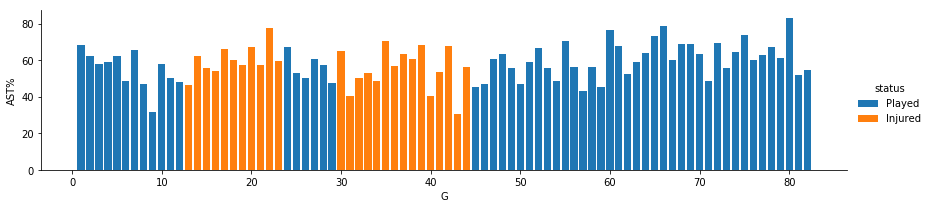

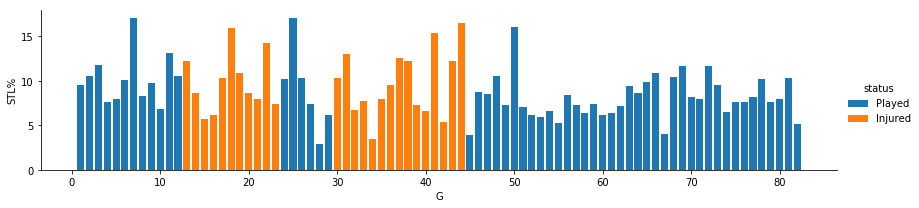

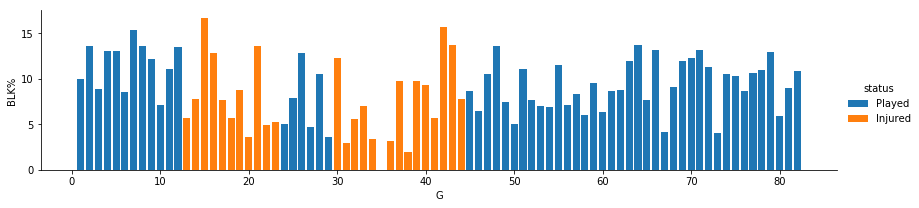

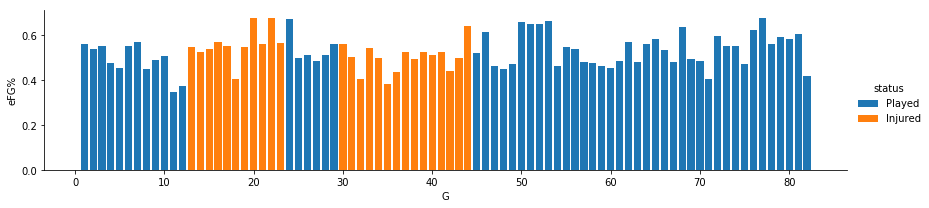

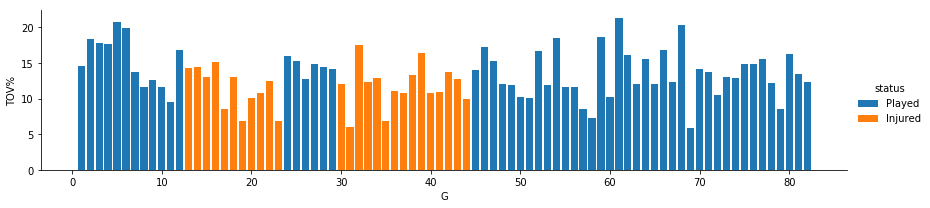

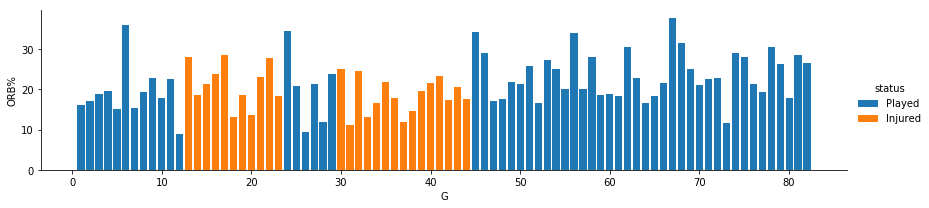

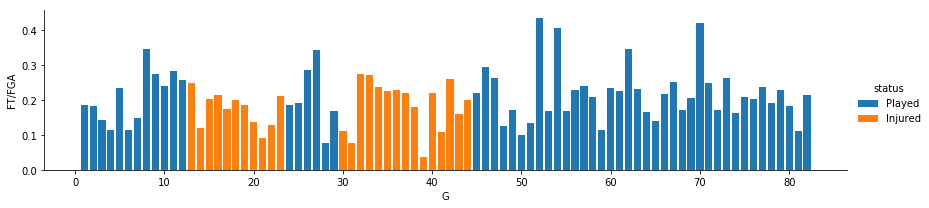

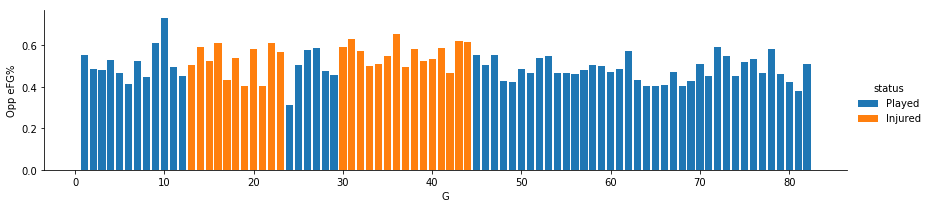

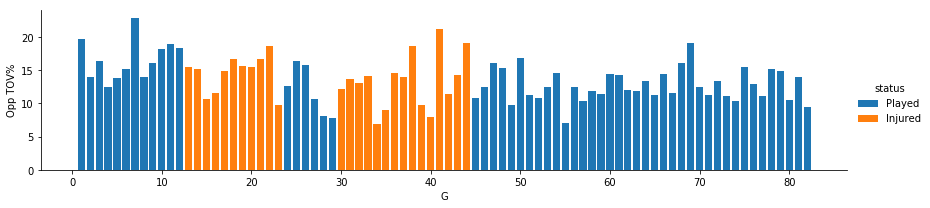

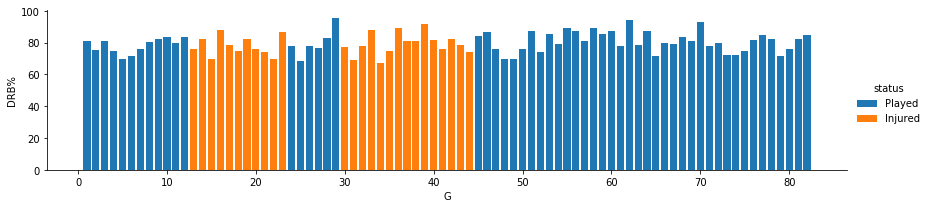

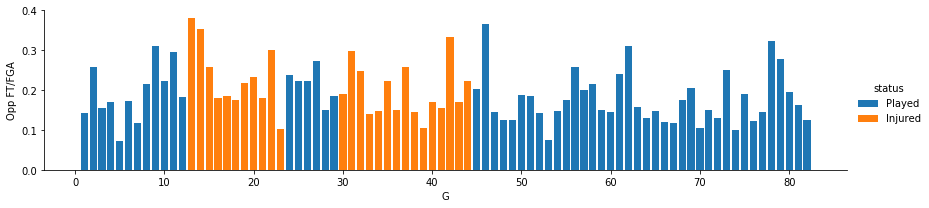

In [28]:
plot_all_stats(rudy_gobert, 2018)

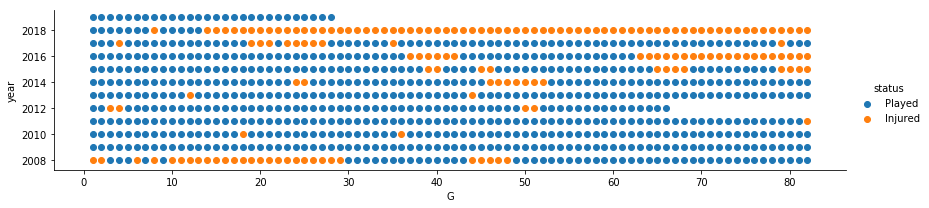

In [22]:
conley = get_game_log('Mike Conley', start_year=2005)
plot_viz(conley)

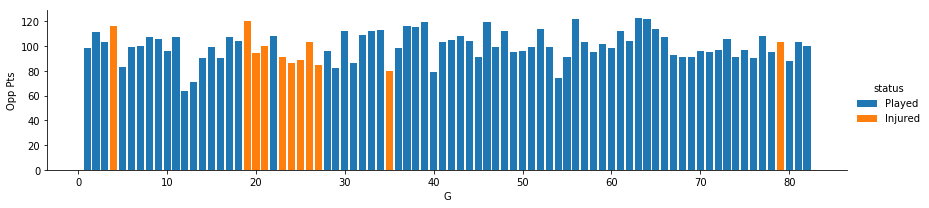

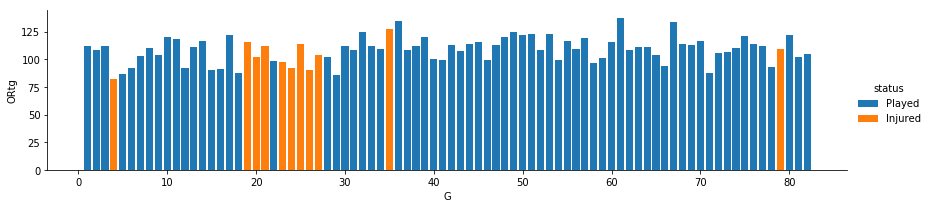

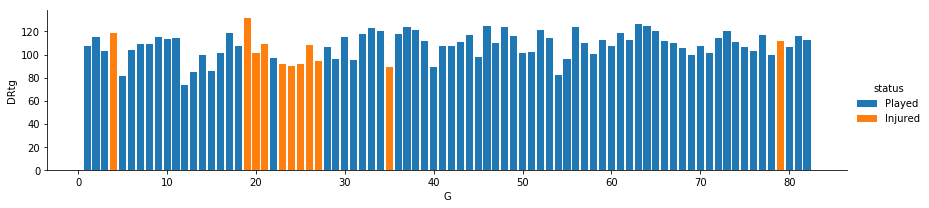

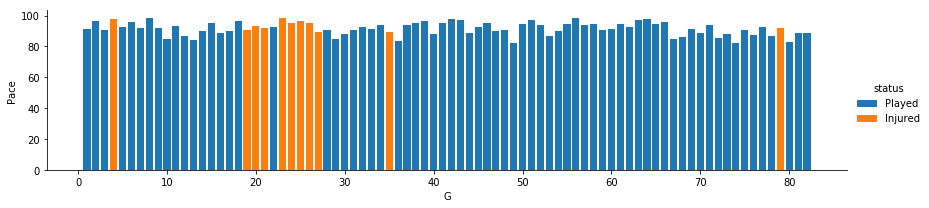

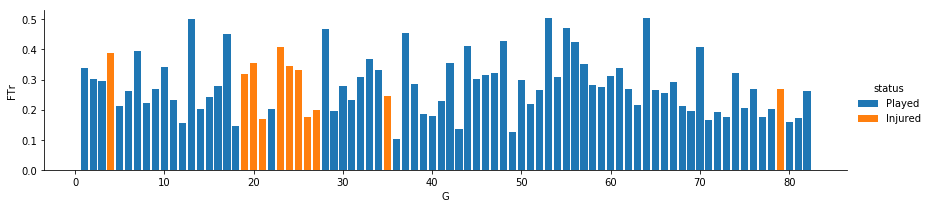

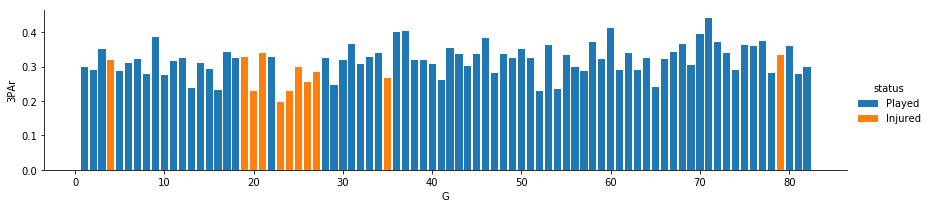

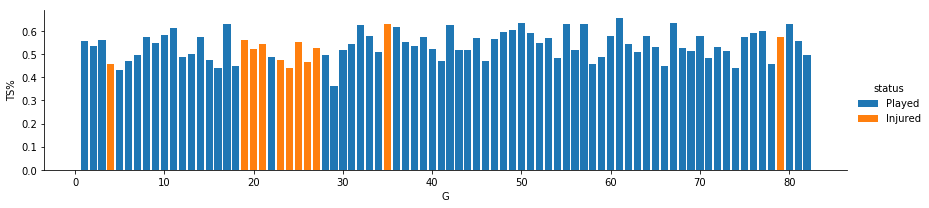

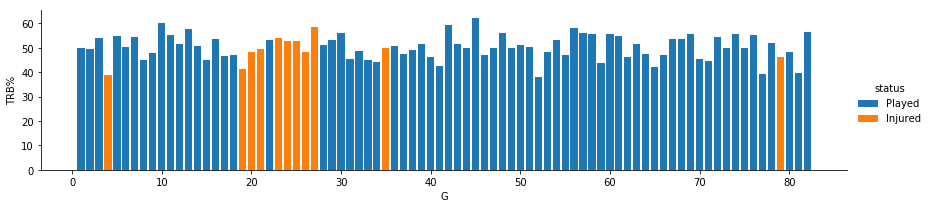

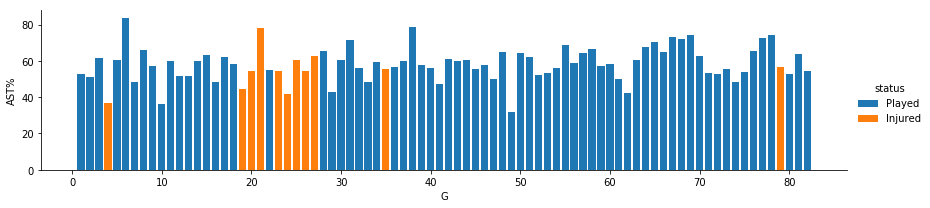

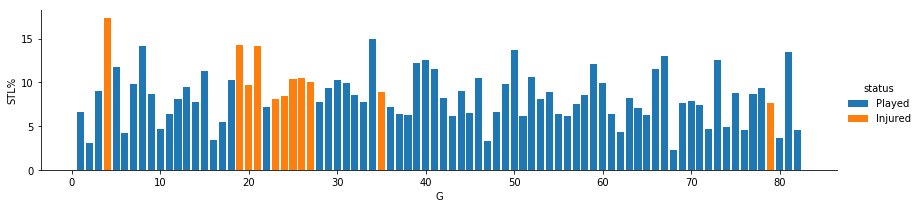

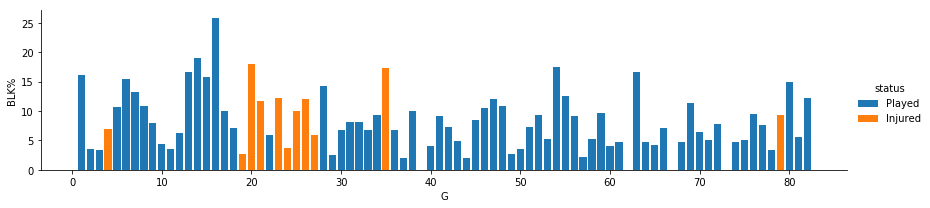

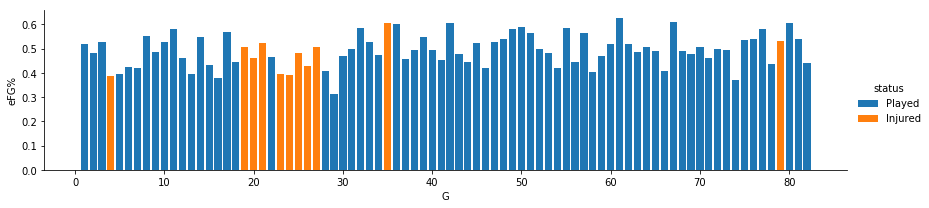

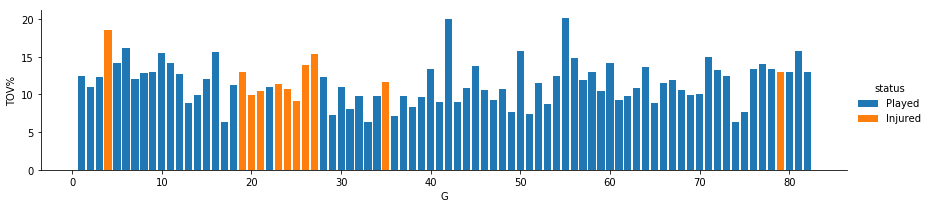

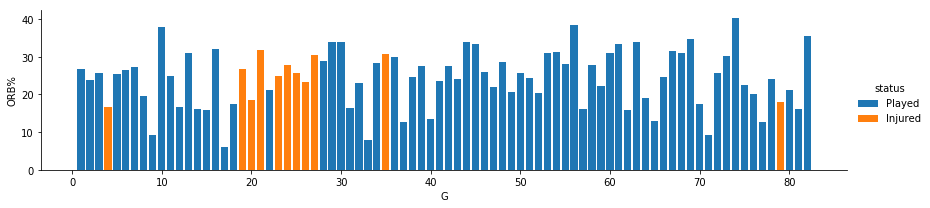

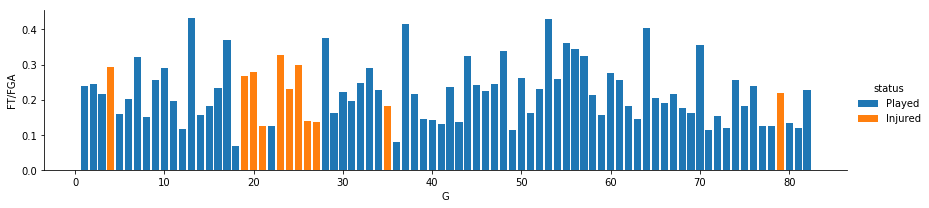

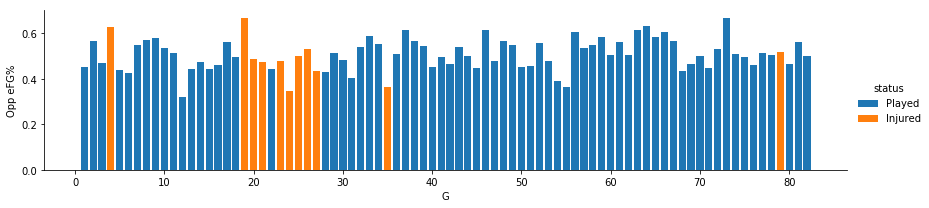

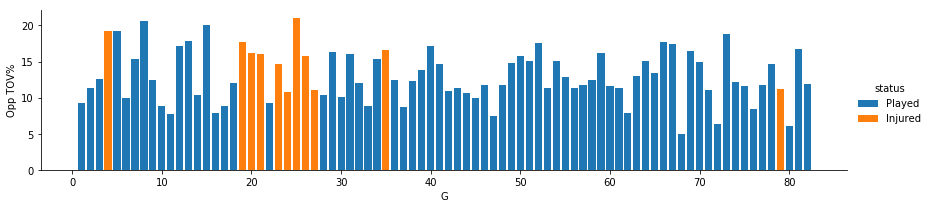

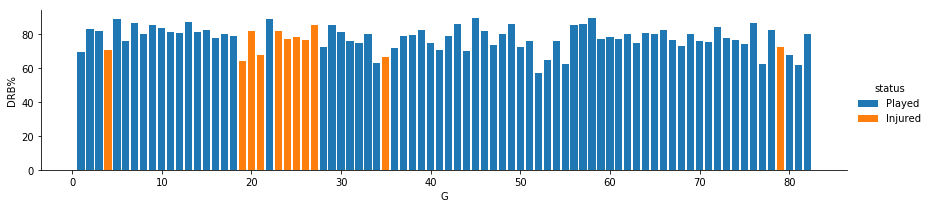

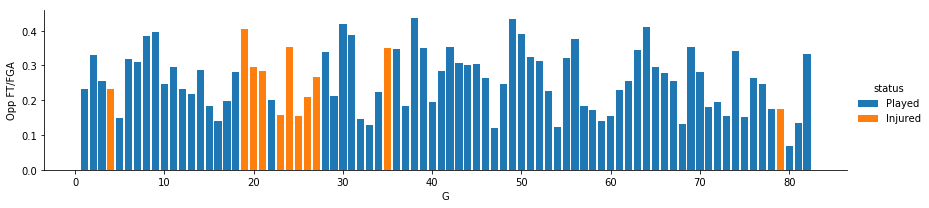

In [26]:
plot_all_stats(conley, 2017)